# Cleaning data and the skies

## 💾 The data
The data is a modified dataset from the U.S. Environmental Protection Agency ([EPA](https://www.epa.gov/outdoor-air-quality-data/download-daily-data)). 

#### Ozone contains the daily air quality summary statistics by monitor for the state of California for 2024. Each row contains the date and the air quality metrics per collection method and site
- "Date" - the calendar date with which the air quality values are associated
- "Source" - the data source: EPA's Air Quality System (AQS), or Airnow reports
- "Site ID" - the id for the air monitoring site
- "POC" - the id number for the monitor
- "Daily Max 8-hour Ozone Concentration" - the highest 8-hour value of the day for ozone concentration
- "Units" - parts per million by volume (ppm)
- "Daily AQI Value" - the highest air quality index value for the day, telling how clean or polluted the air is (a value of 50 represents good air quality, while a value above 300 is hazardous)
- "Local Site Name" - name of the monitoring site
- "Daily Obs Count" - number of observations reported in that day
- "Percent Complete" - indicates whether all expected samples were collected
- "Method Code" - identifier for the collection method
- "CBSA Code" - identifier for the core base statistical area (CBSA)
- "CBSA Name" - name of the core base statistical area
- "State FIPS Code" - identifier for the state
- "State" - name of the state
- "County FIPS Code" - identifer for the county
- "County" - name of the county
- "Site Latitude" - latitude coordinates of the site
- "Site Longitude" - longitude coordinates of the side

# Executive Summary

Analysis of California's 2024 ozone monitoring data identifies significant regional air quality disparities requiring immediate policy intervention. Central Valley and Inland Empire regions experience the most severe pollution, with Visalia-Porterville recording unhealthy ozone levels on 19.8% of days.

## Key Findings

- **Highest risk areas**: Central Valley Air Basin (Tulare, Kern, Fresno counties) and Inland Empire (San Bernardino, Riverside counties)
- **Peak concentrations**: San Bernardino County averages 0.0553 ppm, with summer levels 40-50% higher than winter
- **Population exposure**: Nearly one in five days reach unhealthy levels in worst-affected regions during peak season
- **Overall status**: 93.8% of monitoring sites maintain EPA "Good" air quality standards annually

## Priority Interventions

**Immediate Actions Required:**
- Agricultural emission controls in Central Valley counties
- Enhanced goods movement standards in Inland Empire
- Real-time air quality alert systems for vulnerable populations
- Standardised monitoring protocols across all sites

Targeted policy interventions in identified hotspots can significantly reduce health risks for California's most vulnerable communities.

# Libraries

In [ ]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

import geopandas as gpd
import requests
import zipfile
from io import BytesIO
import warnings
warnings.filterwarnings('ignore')

from folium.plugins import HeatMap
import folium

ozone = pd.read_csv('data/ozone.csv')
ozone.head()

Date Source   Site ID  ...   County  Site Latitude Site Longitude
0            /2024    AQS  60010007  ...  Alameda      37.687526    -121.784217
1       01/02/2024    AQS  60010007  ...  Alameda      37.687526    -121.784217
2            /2024    AQS  60010007  ...  Alameda      37.687526    -121.784217
3  January 04/2024    AQS  60010007  ...  Alameda      37.687526    -121.784217
4  January 05/2024    AQS  60010007  ...  Alameda      37.687526    -121.784217

[5 rows x 17 columns]

# Exploratory Data Analysis (EDA)

## Data Summary

Let's examine our ozone dataset to understand its structure, dimensions, and potential issues before performing any analysis.

In [2]:
ozone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54759 entries, 0 to 54758
Data columns (total 17 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Date                                  54759 non-null  object 
 1   Source                                54759 non-null  object 
 2   Site ID                               54759 non-null  int64  
 3   POC                                   54759 non-null  int64  
 4   Daily Max 8-hour Ozone Concentration  52021 non-null  float64
 5   Units                                 54759 non-null  object 
 6   Daily AQI Value                       52021 non-null  float64
 7   Local Site Name                       54759 non-null  object 
 8   Daily Obs Count                       54759 non-null  int64  
 9   Percent Complete                      54759 non-null  float64
 10  Method Code                           48269 non-null  float64
 11  CBSA Code      

The dataset contains 54,759 rows and 16 columns, representing daily ozone measurements from various monitoring stations across California for 2024. Key observations:

- **Missing Values**: There are some missing values in the "Daily Max 8-hour Ozone Concentration" column and the same amount in "Daily AQI Value", indicating these metrics are directly related.
  
- **Measurement Methods**: "Method Code" also has missing values, suggesting incomplete documentation of collection methodologies.

## Statistical Summary

Let's examine the key statistical characteristics of our dataset to understand the distribution of ozone measurements and other numerical variables. This will help identify potential outliers and understand the central tendencies of our data. It will also help us determine what values might be considered normal versus anomalous in our dataset.



In [3]:
ozone.describe()

Site ID           POC  ...  Site Latitude  Site Longitude
count  5.475900e+04  54759.000000  ...   54759.000000    54759.000000
mean   6.059086e+07      1.000256  ...      36.169550     -119.665107
std    3.001943e+05      0.015988  ...       2.192841        2.022987
min    6.001001e+07      1.000000  ...      32.578165     -124.179490
25%    6.031100e+07      1.000000  ...      34.181977     -121.420838
50%    6.065500e+07      1.000000  ...      36.209286     -119.828400
75%    6.081100e+07      1.000000  ...      37.961578     -118.068500
max    6.113100e+07      2.000000  ...      41.726892     -114.602090

[8 rows x 11 columns]

The statistical analysis reveals important characteristics of our key measurements:

- **Ozone Concentration**: 
  - Range: 0 to 0.1390 ppm
  - Mean: 0.043519 ppm
  - Median (50%): 0.0410 ppm
  - The min range (0 ppm) might be missing values or days with no ozone detected
  - The mean (0.0435 ppm) and median (0.0410 ppm) are very close, which suggests a nearly symmetric distribution

- **Daily AQI Value**:
  - Range: 0 to 236
  - Mean: 45.28
  - Median (50%): 38
  - Most values fall within acceptable air quality ranges, but some extreme values (236) indicate hazardous conditions

- **Daily Obs Count**:
  - Range: 1 to 1000
  - Mean: 27.5347
  - Median (50%): 17
  - The maximum daily observation count of 1000 is an outlier, suggesting a deeper investigation

- **Geographic Coverage**:
  - Sites spread across latitudes (32.58°N to 41.73°N) and longitudes (-124.18°E to -114.60°E)
  - This covers the entire state of California from the coast to inland regions

- **Data Completeness**:
  - Most measurements show 100% completeness (mean 99.34%)

This initial analysis suggests the data is generally reliable with some outliers that warrant further investigation, especially in the high AQI ranges and daily observation counts.

## Fix Date Format and Add Derived Date Features

In [4]:
# Convert Date column to datetime
ozone['Date'] = pd.to_datetime(ozone['Date'], errors='coerce')

# Check for any invalid dates that couldn't be parsed
invalid_dates = ozone['Date'].isna().sum()
print(f"Number of invalid dates: {invalid_dates}")

# Add derived date features for analysis
ozone['DayOfWeek'] = ozone['Date'].dt.dayofweek  # 0=Monday, 6=Sunday
ozone['IsWeekend'] = ozone['DayOfWeek'].isin([5, 6])  # Saturday and Sunday
ozone.drop(columns=['DayOfWeek'], inplace=True)  # Drop if not needed

print(f"\nDate range: {ozone['Date'].min()} to {ozone['Date'].max()}")
ozone.head(3)

Number of invalid dates: 0

Date range: 2024-01-01 00:00:00 to 2024-12-31 00:00:00


Date Source   Site ID  ...  Site Latitude  Site Longitude IsWeekend
0 2024-01-01    AQS  60010007  ...      37.687526     -121.784217     False
1 2024-01-02    AQS  60010007  ...      37.687526     -121.784217     False
2 2024-01-01    AQS  60010007  ...      37.687526     -121.784217     False

[3 rows x 18 columns]

## Missing Values

In [5]:
ozone.isna().sum()

Date                                       0
Source                                     0
Site ID                                    0
POC                                        0
Daily Max 8-hour Ozone Concentration    2738
Units                                      0
Daily AQI Value                         2738
Local Site Name                            0
Daily Obs Count                            0
Percent Complete                           0
Method Code                             6490
CBSA Code                               2408
CBSA Name                               2408
County FIPS Code                           0
County                                     0
Site Latitude                              0
Site Longitude                             0
IsWeekend                                  0
dtype: int64

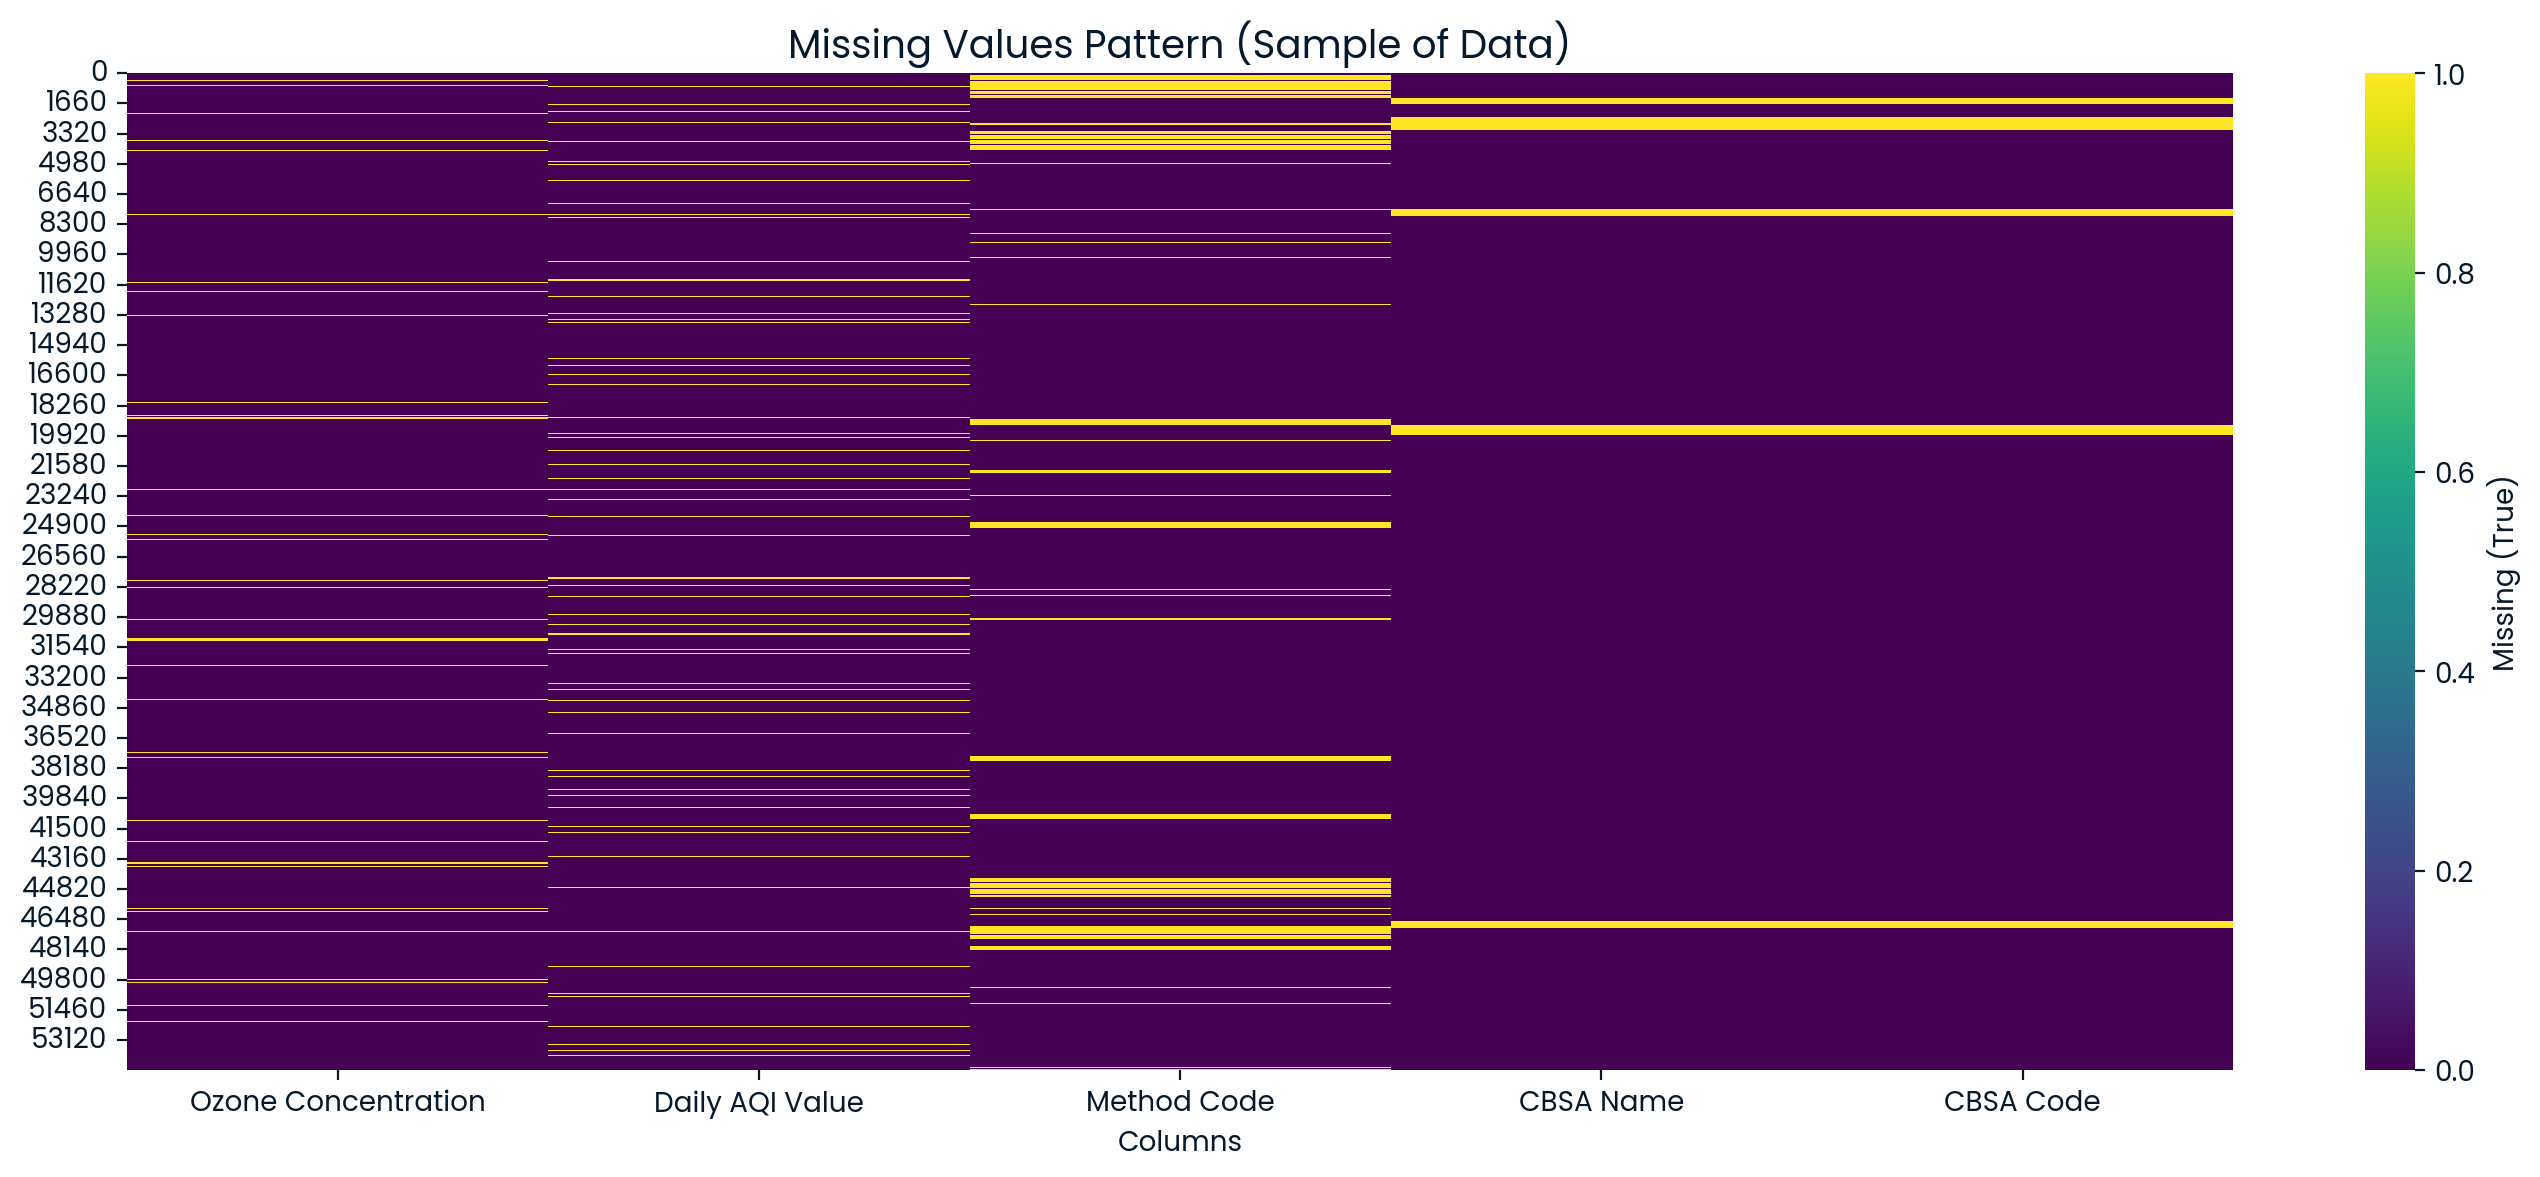


Missing Values Percentage:
Ozone Concentration     5.00
Daily AQI Value         5.00
Method Code            11.85
CBSA Name               4.40
CBSA Code               4.40
dtype: float64


In [6]:
# Create a mask for missing values in the dataset (True for missing, False for present)
missing_mask = ozone.isna()

# Select only the columns with missing values for the visualisation
columns_with_missing = ['Daily Max 8-hour Ozone Concentration', 'Daily AQI Value', 'Method Code', 'CBSA Name', 'CBSA Code']
missing_subset = missing_mask[columns_with_missing].rename(columns={'Daily Max 8-hour Ozone Concentration': 'Ozone Concentration'})

# Calculate the percentage of missing values per column
missing_percentages = round(missing_subset.mean() * 100, 2)

# Create a figure with two subplots
fig, ax = plt.subplots(1, 1, figsize=(14, 6))

# Missing values heatmap
sns.heatmap(missing_subset, cmap='viridis', cbar_kws={'label': 'Missing (True)'})
ax.set_title('Missing Values Pattern (Sample of Data)', fontsize=14)
ax.set_xlabel('Columns')

plt.tight_layout()
plt.show()

print("\nMissing Values Percentage:")
print(missing_percentages)

In [7]:
# Check for rows where both ozone concentration and AQI values are missing
both_missing = ozone[ozone['Daily Max 8-hour Ozone Concentration'].isna() & ozone['Daily AQI Value'].isna()]

# Count how many rows have both values missing
print(f"Number of rows with both ozone concentration and AQI missing: {len(both_missing)}")

# Check if there are rows where only one value is missing
only_ozone_missing = ozone[ozone['Daily Max 8-hour Ozone Concentration'].isna() & ~ozone['Daily AQI Value'].isna()]
only_aqi_missing = ozone[~ozone['Daily Max 8-hour Ozone Concentration'].isna() & ozone['Daily AQI Value'].isna()]

print(f"Number of rows with only ozone concentration missing: {len(only_ozone_missing)}")
print(f"Number of rows with only AQI missing: {len(only_aqi_missing)}")

# Check for misalignment between ozone concentration and AQI values
# (when one exists but the other doesn't)
misaligned = len(only_ozone_missing) + len(only_aqi_missing)
print(f"Total rows with misaligned data: {misaligned}")

# Display a sample of misaligned data
if len(only_ozone_missing) > 0:
  print("\nSample where ozone is missing but AQI exists:")
  print(only_ozone_missing[['Date', 'Daily Max 8-hour Ozone Concentration', 'Daily AQI Value', 'Local Site Name']].head(3).rename(columns={'Daily Max 8-hour Ozone Concentration': 'Ozone Concentration'}))

if len(only_aqi_missing) > 0:
  print("\nSample where AQI is missing but ozone exists:")
  print(only_aqi_missing[['Date', 'Daily Max 8-hour Ozone Concentration', 'Daily AQI Value', 'Local Site Name']].head(3).rename(columns={'Daily Max 8-hour Ozone Concentration': 'Ozone Concentration'}))

Number of rows with both ozone concentration and AQI missing: 136
Number of rows with only ozone concentration missing: 2602
Number of rows with only AQI missing: 2602
Total rows with misaligned data: 5204

Sample where ozone is missing but AQI exists:
         Date  Ozone Concentration  Daily AQI Value Local Site Name
2  2024-01-01                  NaN             30.0       Livermore
39 2024-01-15                  NaN             21.0         Oakland
67 2024-02-12                  NaN             19.0         Oakland

Sample where AQI is missing but ozone exists:
         Date  Ozone Concentration  Daily AQI Value Local Site Name
12 2024-01-13                0.032              NaN       Livermore
25 2024-01-01                0.024              NaN         Oakland
63 2024-01-01                0.029              NaN         Oakland


## Handling Missing Values

Since AQI values are calculated from ozone concentrations (and vice versa) using EPA conversion formulas, we can use one to derive the other. For records where both values are missing (136 rows, representing just 0.25% of our dataset), we'll remove these rows rather than imputing values, which could introduce bias.

U.S. Environment Protection Agency (EPA) standard breakpoints for ozone:
  AQI Category    | Index Values | Ozone (ppm, 8-hour)
  ---------------|-------------|------------------
  Good           | 0-50        | 0-0.054
  Moderate       | 51-100      | 0.055-0.070
  Unhealthy for Sensitive Groups | 101-150     | 0.071-0.085
  Unhealthy      | 151-200     | 0.086-0.105
  Very Unhealthy | 201-300     | 0.106-0.200
  Hazardous      | 301-500     | 0.201-0.604

In [8]:
def convert_ozone_aqi(value, reverse=False):
  """
  Convert between ozone concentration (ppm) and AQI values.
  
  Parameters
  ----------
  value : float
    The value to convert. Either ozone concentration (ppm) or AQI value.
  reverse : bool, optional
    If False (default), convert from ozone concentration to AQI.
    If True, convert from AQI to ozone concentration.
    
  Returns
  -------
  float
    The converted value. Either AQI value or ozone concentration (ppm).
    Returns None if the input is outside the valid range.
  
  Notes
  -----
  Formula for conversion:
  AQI = ((I_high - I_low) / (C_high - C_low)) * (C - C_low) + I_low
  Where:
  - I_high, I_low: AQI breakpoints
  - C_high, C_low: Concentration breakpoints
  - C: Concentration to convert
  """
  # Define breakpoints for ozone concentration (ppm) and AQI
  breakpoints = [
    (0.000, 0.054, 0, 50),    # Good
    (0.055, 0.070, 51, 100),  # Moderate
    (0.071, 0.085, 101, 150), # Unhealthy for Sensitive Groups
    (0.086, 0.105, 151, 200), # Unhealthy
    (0.106, 0.200, 201, 300), # Very Unhealthy
    (0.201, 0.604, 301, 500)  # Hazardous
  ]
  
  if not reverse:  # Ozone concentration to AQI
    if value is None or value < 0:
      return None
      
    # Find the appropriate breakpoint range
    for c_low, c_high, i_low, i_high in breakpoints:
      if c_low <= value <= c_high:
        # Apply the formula for converting concentration to AQI
        aqi = ((i_high - i_low) / (c_high - c_low)) * (value - c_low) + i_low
        return round(aqi)
        
    # If value is above the highest range
    if value > breakpoints[-1][1]:
      return 500  # Maximum AQI value
    return 0  # Default for very low values
    
  else:  # AQI to ozone concentration
    if value is None or value < 0 or value > 500:
      return None
      
    # Find the appropriate breakpoint range
    for c_low, c_high, i_low, i_high in breakpoints:
      if i_low <= value <= i_high:
        # Apply the formula for converting AQI to concentration
        conc = ((c_high - c_low) / (i_high - i_low)) * (value - i_low) + c_low
        return round(conc, 4)
        
    return 0  # Default for very low values

In [9]:
# First, handle missing values where both concentration and AQI are null
# These records can't be reliably filled, so we'll drop them
print("Number of records before dropping rows with both values missing:", len(ozone))
ozone_clean = ozone.dropna(subset=['Daily Max 8-hour Ozone Concentration', 'Daily AQI Value'], how='all')
print("Number of records after dropping rows with both values missing:", len(ozone_clean))

# For records where only one value is missing, use the conversion function to fill in the other
# Where Ozone Concentration exists but AQI is missing
mask_fill_aqi = ozone_clean['Daily Max 8-hour Ozone Concentration'].notna() & ozone_clean['Daily AQI Value'].isna()
ozone_clean.loc[mask_fill_aqi, 'Daily AQI Value'] = ozone_clean.loc[mask_fill_aqi, 'Daily Max 8-hour Ozone Concentration'].apply(convert_ozone_aqi)

# Where AQI exists but Ozone Concentration is missing
mask_fill_ozone = ozone_clean['Daily Max 8-hour Ozone Concentration'].isna() & ozone_clean['Daily AQI Value'].notna()
ozone_clean.loc[mask_fill_ozone, 'Daily Max 8-hour Ozone Concentration'] = ozone_clean.loc[mask_fill_ozone, 'Daily AQI Value'].apply(lambda x: convert_ozone_aqi(x, reverse=True))

# Check if there are still missing values after filling
missing_after = ozone_clean[['Daily Max 8-hour Ozone Concentration', 'Daily AQI Value']].isna().sum()
print("\nRemaining missing values after filling:")
print(missing_after)

# Verify with a sample of records that were filled
print("\nSample of records where AQI was calculated from ozone concentration:")
print(ozone_clean.loc[mask_fill_aqi].head(3)[['Date', 'Daily Max 8-hour Ozone Concentration', 'Daily AQI Value', 'Local Site Name']].rename(columns={'Daily Max 8-hour Ozone Concentration': 'Ozone Concentration'}))

print("\nSample of records where ozone concentration was calculated from AQI:")
print(ozone_clean.loc[mask_fill_ozone].head(3)[['Date', 'Daily Max 8-hour Ozone Concentration', 'Daily AQI Value', 'Local Site Name']].rename(columns={'Daily Max 8-hour Ozone Concentration': 'Ozone Concentration'}))

# Verify the relationship between concentration and AQI with a sample of filled values
sample_size = min(10, len(mask_fill_aqi[mask_fill_aqi]), len(mask_fill_ozone[mask_fill_ozone]))
fill_comparison = pd.DataFrame({
  'Original Ozone': ozone_clean.loc[mask_fill_aqi, 'Daily Max 8-hour Ozone Concentration'].head(sample_size),
  'Calculated Ozone': ozone_clean.loc[mask_fill_ozone, 'Daily Max 8-hour Ozone Concentration'].head(sample_size),
  'Original AQI': ozone_clean.loc[mask_fill_ozone, 'Daily AQI Value'].head(sample_size),
  'Calculated AQI': ozone_clean.loc[mask_fill_aqi, 'Daily AQI Value'].head(sample_size),
})

print("\nComparison of original and calculated values:")
print(fill_comparison)

Number of records before dropping rows with both values missing: 54759
Number of records after dropping rows with both values missing: 54623

Remaining missing values after filling:
Daily Max 8-hour Ozone Concentration    0
Daily AQI Value                         0
dtype: int64

Sample of records where AQI was calculated from ozone concentration:
         Date  Ozone Concentration  Daily AQI Value Local Site Name
12 2024-01-13                0.032             30.0       Livermore
25 2024-01-01                0.024             22.0         Oakland
63 2024-01-01                0.029             27.0         Oakland

Sample of records where ozone concentration was calculated from AQI:
         Date  Ozone Concentration  Daily AQI Value Local Site Name
2  2024-01-01               0.0324             30.0       Livermore
39 2024-01-15               0.0227             21.0         Oakland
67 2024-02-12               0.0205             19.0         Oakland

Comparison of original and calculate

## Feature Selection

In [10]:
# First, let's see all column names
print("All columns in the dataset:")
print(ozone_clean.columns)

All columns in the dataset:
Index(['Date', 'Source', 'Site ID', 'POC',
       'Daily Max 8-hour Ozone Concentration', 'Units', 'Daily AQI Value',
       'Local Site Name', 'Daily Obs Count', 'Percent Complete', 'Method Code',
       'CBSA Code', 'CBSA Name', 'County FIPS Code', 'County', 'Site Latitude',
       'Site Longitude', 'IsWeekend'],
      dtype='object')


In [11]:
print("\n" + "="*50)
print("Column analysis for potential removal:")

print("\n1. Source column:")
print(f"Unique values: {ozone_clean['Source'].unique()}")
print(f"Value counts: {ozone_clean['Source'].value_counts()}")

print("\n2. POC column (Parameter Occurrence Code):")
print(f"Unique values: {ozone_clean['POC'].unique()}")
print(f"Value counts: {ozone_clean['POC'].value_counts()}")

print("\n3. Units column:")
print(f"Unique values: {ozone_clean['Units'].unique()}")
print(f"Value counts: {ozone_clean['Units'].value_counts()}")

print("\n4. Method Code:")
print(f"Unique values: {ozone_clean['Method Code'].unique()}")
print(f"Value counts: {ozone_clean['Method Code'].value_counts()}")


Column analysis for potential removal:

1. Source column:
Unique values: ['AQS' 'AirNow']
Value counts: Source
AQS       48150
AirNow     6473
Name: count, dtype: int64

2. POC column (Parameter Occurrence Code):
Unique values: [1 2]
Value counts: POC
1    54609
2       14
Name: count, dtype: int64

3. Units column:
Unique values: ['ppm']
Value counts: Units
ppm    54623
Name: count, dtype: int64

4. Method Code:
Unique values: [ 47.  nan  87. 199.  53.]
Value counts: Method Code
87.0     35187
47.0      8525
199.0     4047
53.0       391
Name: count, dtype: int64


Based on the analysis of column uniqueness and value counts, 'Units' column contains only 'ppm' (parts per million) for all records. Since all measurements use the same unit, this column adds no analytical value and can be safely removed. 

### Remove Columns

Along with 'Units' column, 'CBSA Code' and 'County FIPS Code' can be safely removed because they represent the 'CBSA Name' and 'County' columns in numerical format, which is redundant.

In [12]:
ozone_reduced = ozone_clean.drop(columns=['Units', 'CBSA Code', 'County FIPS Code'])
ozone_reduced.head(3)

Date Source   Site ID  ...  Site Latitude  Site Longitude  IsWeekend
0 2024-01-01    AQS  60010007  ...      37.687526     -121.784217      False
1 2024-01-02    AQS  60010007  ...      37.687526     -121.784217      False
2 2024-01-01    AQS  60010007  ...      37.687526     -121.784217      False

[3 rows x 15 columns]

## Identify Outliers

Before proceeding with detailed analysis, we need to identify outliers in our key numerical variables: 'Daily Max 8-hour Ozone Concentration', 'Daily AQI Value', and 'Daily Obs Count'. These outliers could represent either data errors or important extreme air quality events. We'll use boxplots to visualise the distribution of these key metrics and identify statistical outliers.

<Figure size 1600x1200 with 0 Axes>

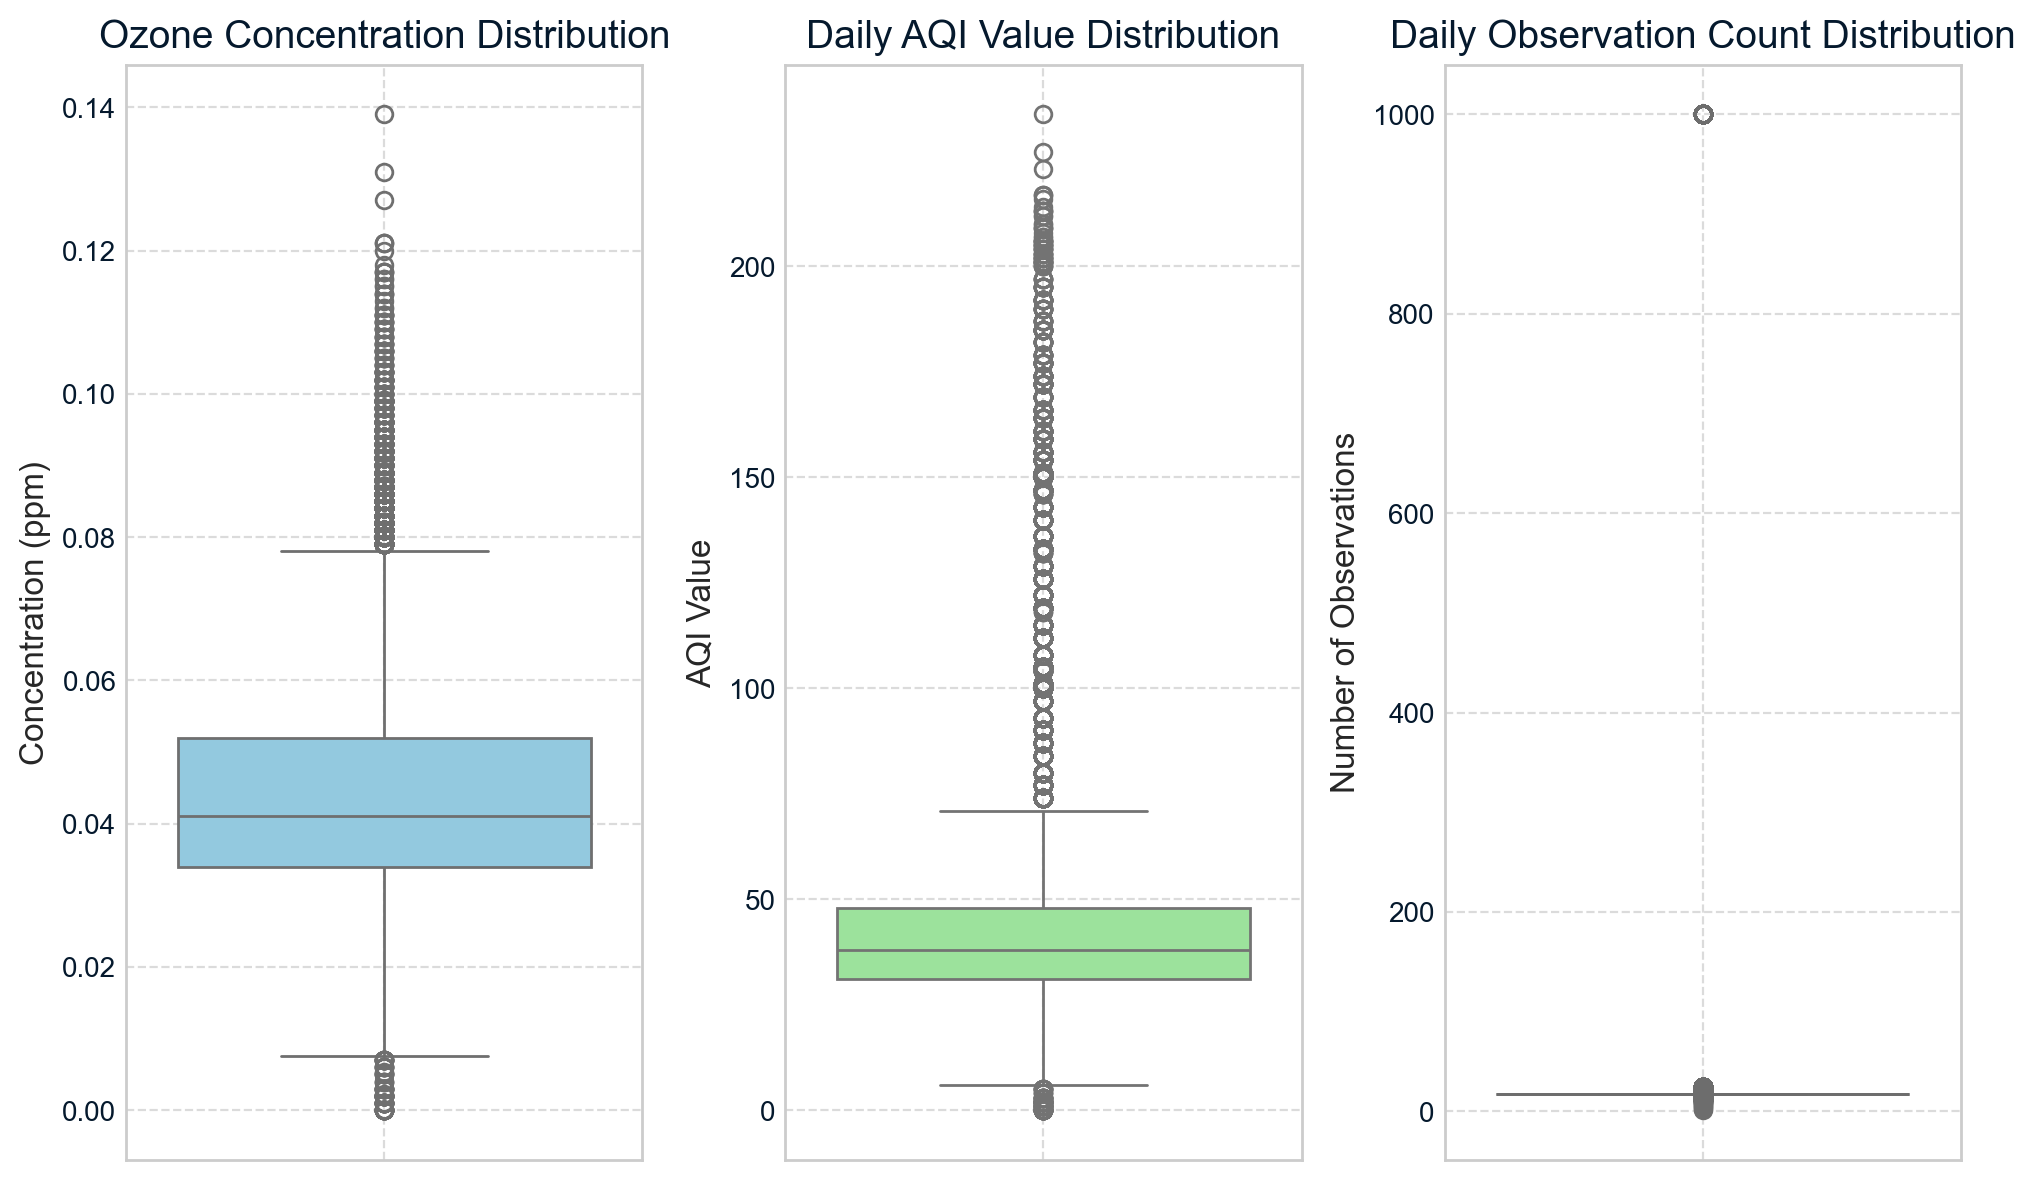

In [13]:
# Set the style for better visualisation
plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(16, 12))

# Create a 2x2 subplot grid
fig, axes = plt.subplots(1, 3, figsize=(10, 6))

# Plot 1: Boxplot for Daily Max 8-hour Ozone Concentration
sns.boxplot(y='Daily Max 8-hour Ozone Concentration', data=ozone_reduced, ax=axes[0], color='skyblue')
axes[0].set_title('Ozone Concentration Distribution', fontsize=14)
axes[0].set_ylabel('Concentration (ppm)', fontsize=12)
axes[0].grid(True, linestyle='--', alpha=0.7)

# Plot 2: Boxplot for Daily AQI Value
sns.boxplot(y='Daily AQI Value', data=ozone_reduced, ax=axes[1], color='lightgreen')
axes[1].set_title('Daily AQI Value Distribution', fontsize=14)
axes[1].set_ylabel('AQI Value', fontsize=12)
axes[1].grid(True, linestyle='--', alpha=0.7)

# Plot 3: Boxplot for Daily Obs Count
sns.boxplot(y='Daily Obs Count', data=ozone_reduced, ax=axes[2], color='salmon')
axes[2].set_title('Daily Observation Count Distribution', fontsize=14)
axes[2].set_ylabel('Number of Observations', fontsize=12)
axes[2].grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

In [14]:
# Print summary statistics of potential outliers
print("\nOutlier Analysis Summary:")
print("-" * 80)
print("Total records:", len(ozone_reduced))
print(f"Ozone Concentration > 0.070 ppm (Unhealthy for Sensitive Groups): {len(ozone_reduced[ozone_reduced['Daily Max 8-hour Ozone Concentration'] > 0.070])} records")
print(f"Ozone Concentration > 0.086 ppm (Unhealthy): {len(ozone_reduced[ozone_reduced['Daily Max 8-hour Ozone Concentration'] > 0.086])} records")
print(f"AQI Value > 100 (Unhealthy for Sensitive Groups): {len(ozone_reduced[ozone_reduced['Daily AQI Value'] > 100])} records")
print(f"AQI Value > 150 (Unhealthy): {len(ozone_reduced[ozone_reduced['Daily AQI Value'] > 150])} records")
print(f"Daily Obs Count = 1000: {len(ozone_reduced[ozone_reduced['Daily Obs Count'] == 1000])} records")


Outlier Analysis Summary:
--------------------------------------------------------------------------------
Total records: 54623
Ozone Concentration > 0.070 ppm (Unhealthy for Sensitive Groups): 2735 records
Ozone Concentration > 0.086 ppm (Unhealthy): 528 records
AQI Value > 100 (Unhealthy for Sensitive Groups): 2735 records
AQI Value > 150 (Unhealthy): 584 records
Daily Obs Count = 1000: 547 records


The boxplots reveal interesting patterns in our data distribution:

- **Ozone Concentration**: Shows some higher values (potential outliers) above 0.12 ppm, which corresponds to "Very Unhealthy" per EPA standards. These aren't likely errors, but rather genuine high pollution events that warrant investigation.

- **AQI Values**: Similarly shows higher values above 220, which aligns with the ozone concentration patterns. These higher values represent actual poor air quality days rather than data errors.

- **Daily Observation Count**: Displays a dramatic bimodal distribution with most values below 50, but a significant cluster at exactly 1000 observations (547 records). This suggests two distinct data collection protocols rather than erroneous values.

### Digging into 1000 Daily Observations

In [15]:
# Filter records with 1000 daily observation counts
ozone_higher_daily_obs = ozone_reduced[ozone_reduced['Daily Obs Count'] == 1000]

# Check the source and statistical summary of these records
print(ozone_higher_daily_obs['Source'].value_counts())
ozone_higher_daily_obs.describe()

Source
AQS       475
AirNow     72
Name: count, dtype: int64


Date  ...  Site Longitude
count                            547  ...      547.000000
mean   2024-05-30 22:54:11.188300032  ...     -119.750598
min              2024-01-01 00:00:00  ...     -124.179490
25%              2024-02-06 00:00:00  ...     -121.368014
50%              2024-05-25 00:00:00  ...     -119.874739
75%              2024-09-09 12:00:00  ...     -118.207905
max              2024-12-29 00:00:00  ...     -114.602090
std                              NaN  ...        1.975573

[8 rows x 10 columns]

The 1000 observation records appear across multiple monitoring sites and sources with mostly 100% completeness, indicating a systematic difference in measurement methodology rather than data entry errors.

## Time Series Analysis

In [16]:
def plot_time_series(df: pd.DataFrame, col_name: str, title: str | None = None, y_label: str | None = None, reference_lines: dict | None = None, rolling_window: int = 7):
      """
      Creates a time series plot with a rolling average for a specified column.
      
      Parameters:
      -----------
      df : pandas.DataFrame
            The dataframe containing the time series data
      col_name : str
            The name of the column to plot
      title : str, optional
            The title for the plot
      y_label : str, optional
            The label for the y-axis
      reference_lines : dict, optional
            Dictionary with threshold values as keys and tuple of (color, label) as values
      rolling_window : int, optional
            Window size for the rolling average, default is 7 days
      """
      # Set the style for better visualisation
      plt.style.use('seaborn-v0_8-whitegrid')
      
      # Create the figure
      plt.figure(figsize=(14, 7))
      
      # Group by date and calculate mean for the column
      daily_avg = df.groupby('Date')[col_name].mean().reset_index()
      
      # Sort by date to ensure proper time sequence
      daily_avg = daily_avg.sort_values('Date')
      
      # Calculate rolling average
      rolling_col = f'{rolling_window}-Day MA'
      daily_avg[rolling_col] = daily_avg[col_name].rolling(window=rolling_window, center=False).mean()
      
      # Plot raw data as light points
      plt.scatter(daily_avg['Date'], daily_avg[col_name], 
                        alpha=0.3, s=15, color='skyblue', label=f'Daily Average')
      
      # Plot the rolling average as a bold line
      plt.plot(daily_avg['Date'], daily_avg[rolling_col], 
                   linewidth=2.5, color='darkblue', label=f'{rolling_window}-Day Moving Average')
      
      # Add reference lines if provided
      if reference_lines:
            for threshold, (color, label) in reference_lines.items():
                  plt.axhline(y=threshold, color=color, linestyle='--', alpha=0.7, label=label)
                  # Add text annotation
                  plt.text(daily_avg['Date'].max(), threshold + 0.002, label, 
                               fontsize=9, va='bottom', ha='right', color=color.replace('yellow', 'darkgoldenrod'))
      
      # Customize the plot
      plt.title(title or f'Daily {col_name} with {rolling_window}-Day Moving Average', fontsize=16)
      plt.xlabel('Date', fontsize=12)
      plt.ylabel(y_label or col_name, fontsize=12)
      plt.grid(True, linestyle='--', alpha=0.7)
      plt.legend(loc='upper left')
      
      # Format x-axis to show months
      plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%b %Y'))
      plt.xticks(rotation=45)
      
      plt.tight_layout()
      plt.show()
      
      return daily_avg

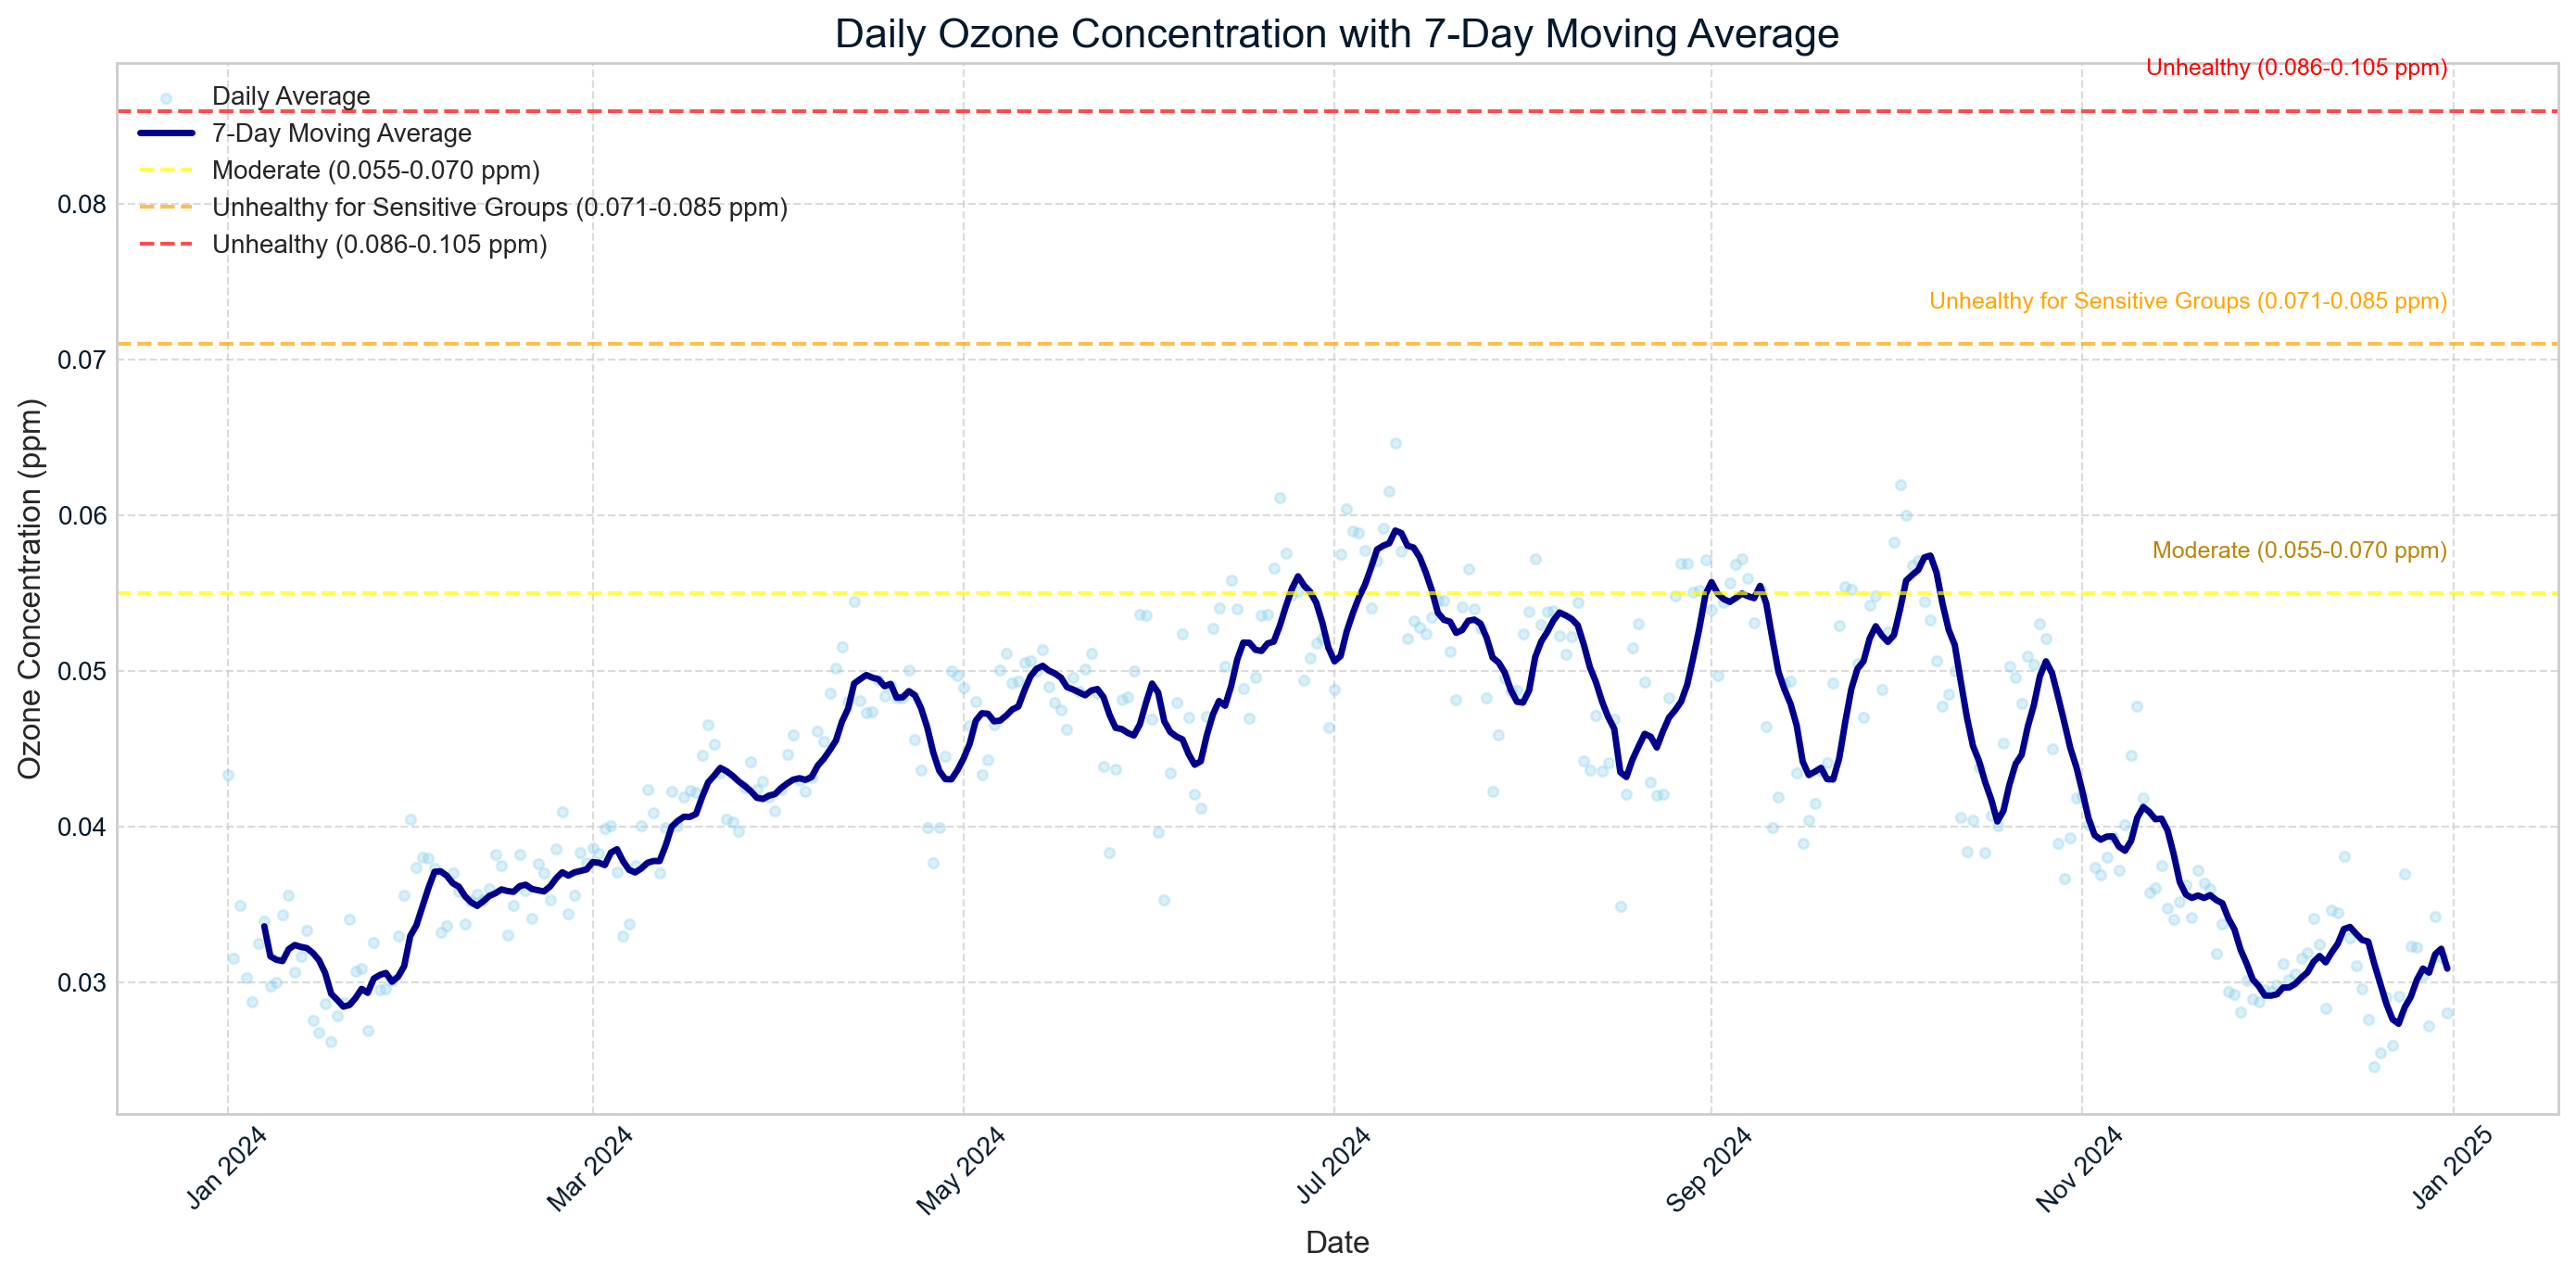

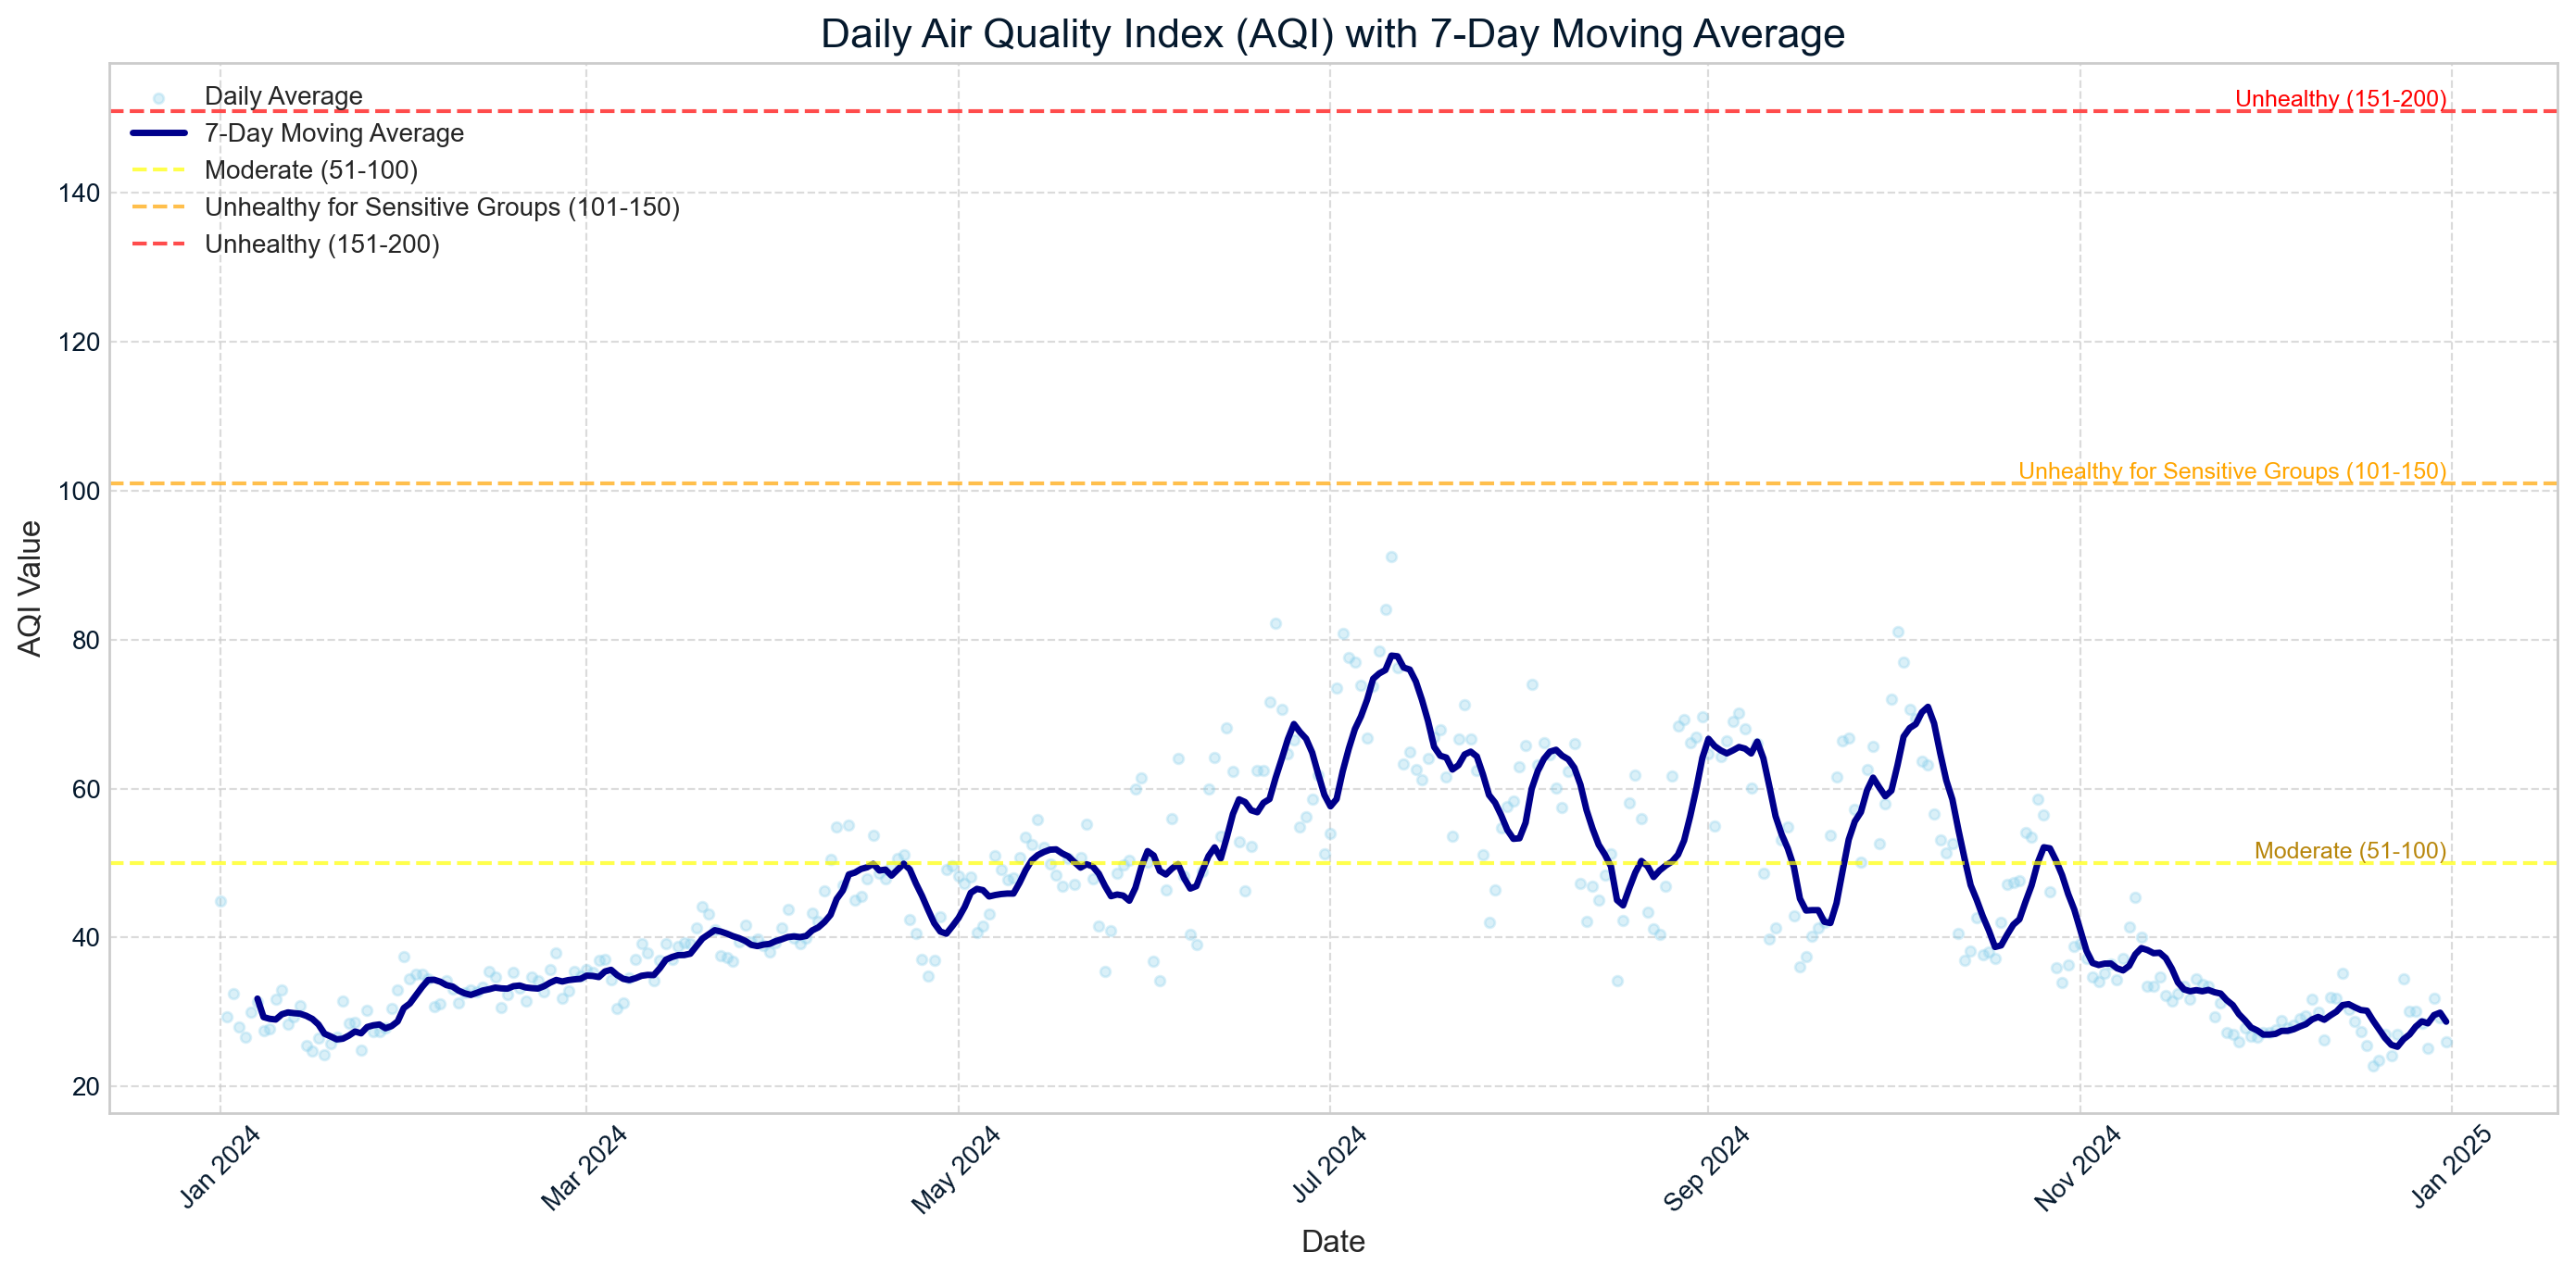

In [17]:
# For ozone concentration, define EPA standard reference lines
reference_lines = {
      0.055: ('yellow', 'Moderate (0.055-0.070 ppm)'),
      0.071: ('orange', 'Unhealthy for Sensitive Groups (0.071-0.085 ppm)'),
      0.086: ('red', 'Unhealthy (0.086-0.105 ppm)')
}

# Call the function with the ozone concentration column
daily_avg = plot_time_series(
      ozone_reduced, 
      'Daily Max 8-hour Ozone Concentration',
      title='Daily Ozone Concentration with 7-Day Moving Average',
      y_label='Ozone Concentration (ppm)',
      reference_lines=reference_lines
)

# For AQI values, define EPA standard reference lines
aqi_reference_lines = {
      50: ('yellow', 'Moderate (51-100)'),
      101: ('orange', 'Unhealthy for Sensitive Groups (101-150)'),
      151: ('red', 'Unhealthy (151-200)')
}

# Call the function with the AQI column
daily_aqi = plot_time_series(
      ozone_reduced, 
      'Daily AQI Value',
      title='Daily Air Quality Index (AQI) with 7-Day Moving Average',
      y_label='AQI Value',
      reference_lines=aqi_reference_lines
)

### Ozone Concentration Trends
- **Seasonal Pattern**: Ozone levels show a clear seasonal cycle, starting low in winter (~0.030 ppm), gradually rising through spring and peaking during summer months (June-September) at ~0.055-0.060 ppm, then declining back to winter levels.
- **Summer Pollution Events**: The highest concentrations occur during summer months, with several periods approaching or exceeding the "Moderate" threshold (0.055 ppm yellow line).
- **7-Day Moving Average**: The moving average (dark blue line) reveals sustained elevated periods during summer, particularly July-September, indicating consistent air quality challenges during warmer months.
- **Winter Recovery**: Clear improvement in air quality during late fall and winter months, with concentrations dropping well below health thresholds.

### AQI Value Trends  
- **Consistent Seasonal Pattern**: The AQI trends perfectly mirror the ozone concentration patterns, validating our data quality and EPA conversion formulas.
- **Summer Deterioration**: AQI values rise significantly during summer months, frequently crossing into the "Moderate" range (51-100) and occasionally approaching the "Unhealthy for Sensitive Groups" threshold.
- **Peak Summer Concerns**: July and August show the most concerning air quality periods, with some daily averages reaching 75-80 AQI.
- **Health Implications**: The elevated summer periods warrant public health attention, particularly for sensitive populations (children, elderly, those with respiratory conditions) who should be aware of outdoor activity limitations during peak summer months.

Both charts demonstrate California's classic Mediterranean air quality pattern, with clean winter air deteriorating during the warmer, sunnier summer months when photochemical ozone formation is enhanced. This seasonal pattern requires targeted summer air quality management strategies.

## Geo-Spatial Analysis

Top 5 Regions with Highest Percentage of Unhealthy Ozone Days:
                               CBSA Name  ...  days_unhealthy_aqi
30               Visalia-Porterville, CA  ...               19.94
15  Riverside-San Bernardino-Ontario, CA  ...               15.13
0                        Bakersfield, CA  ...               11.21
6                             Fresno, CA  ...                9.30
8     Los Angeles-Long Beach-Anaheim, CA  ...                8.96

[5 rows x 5 columns]


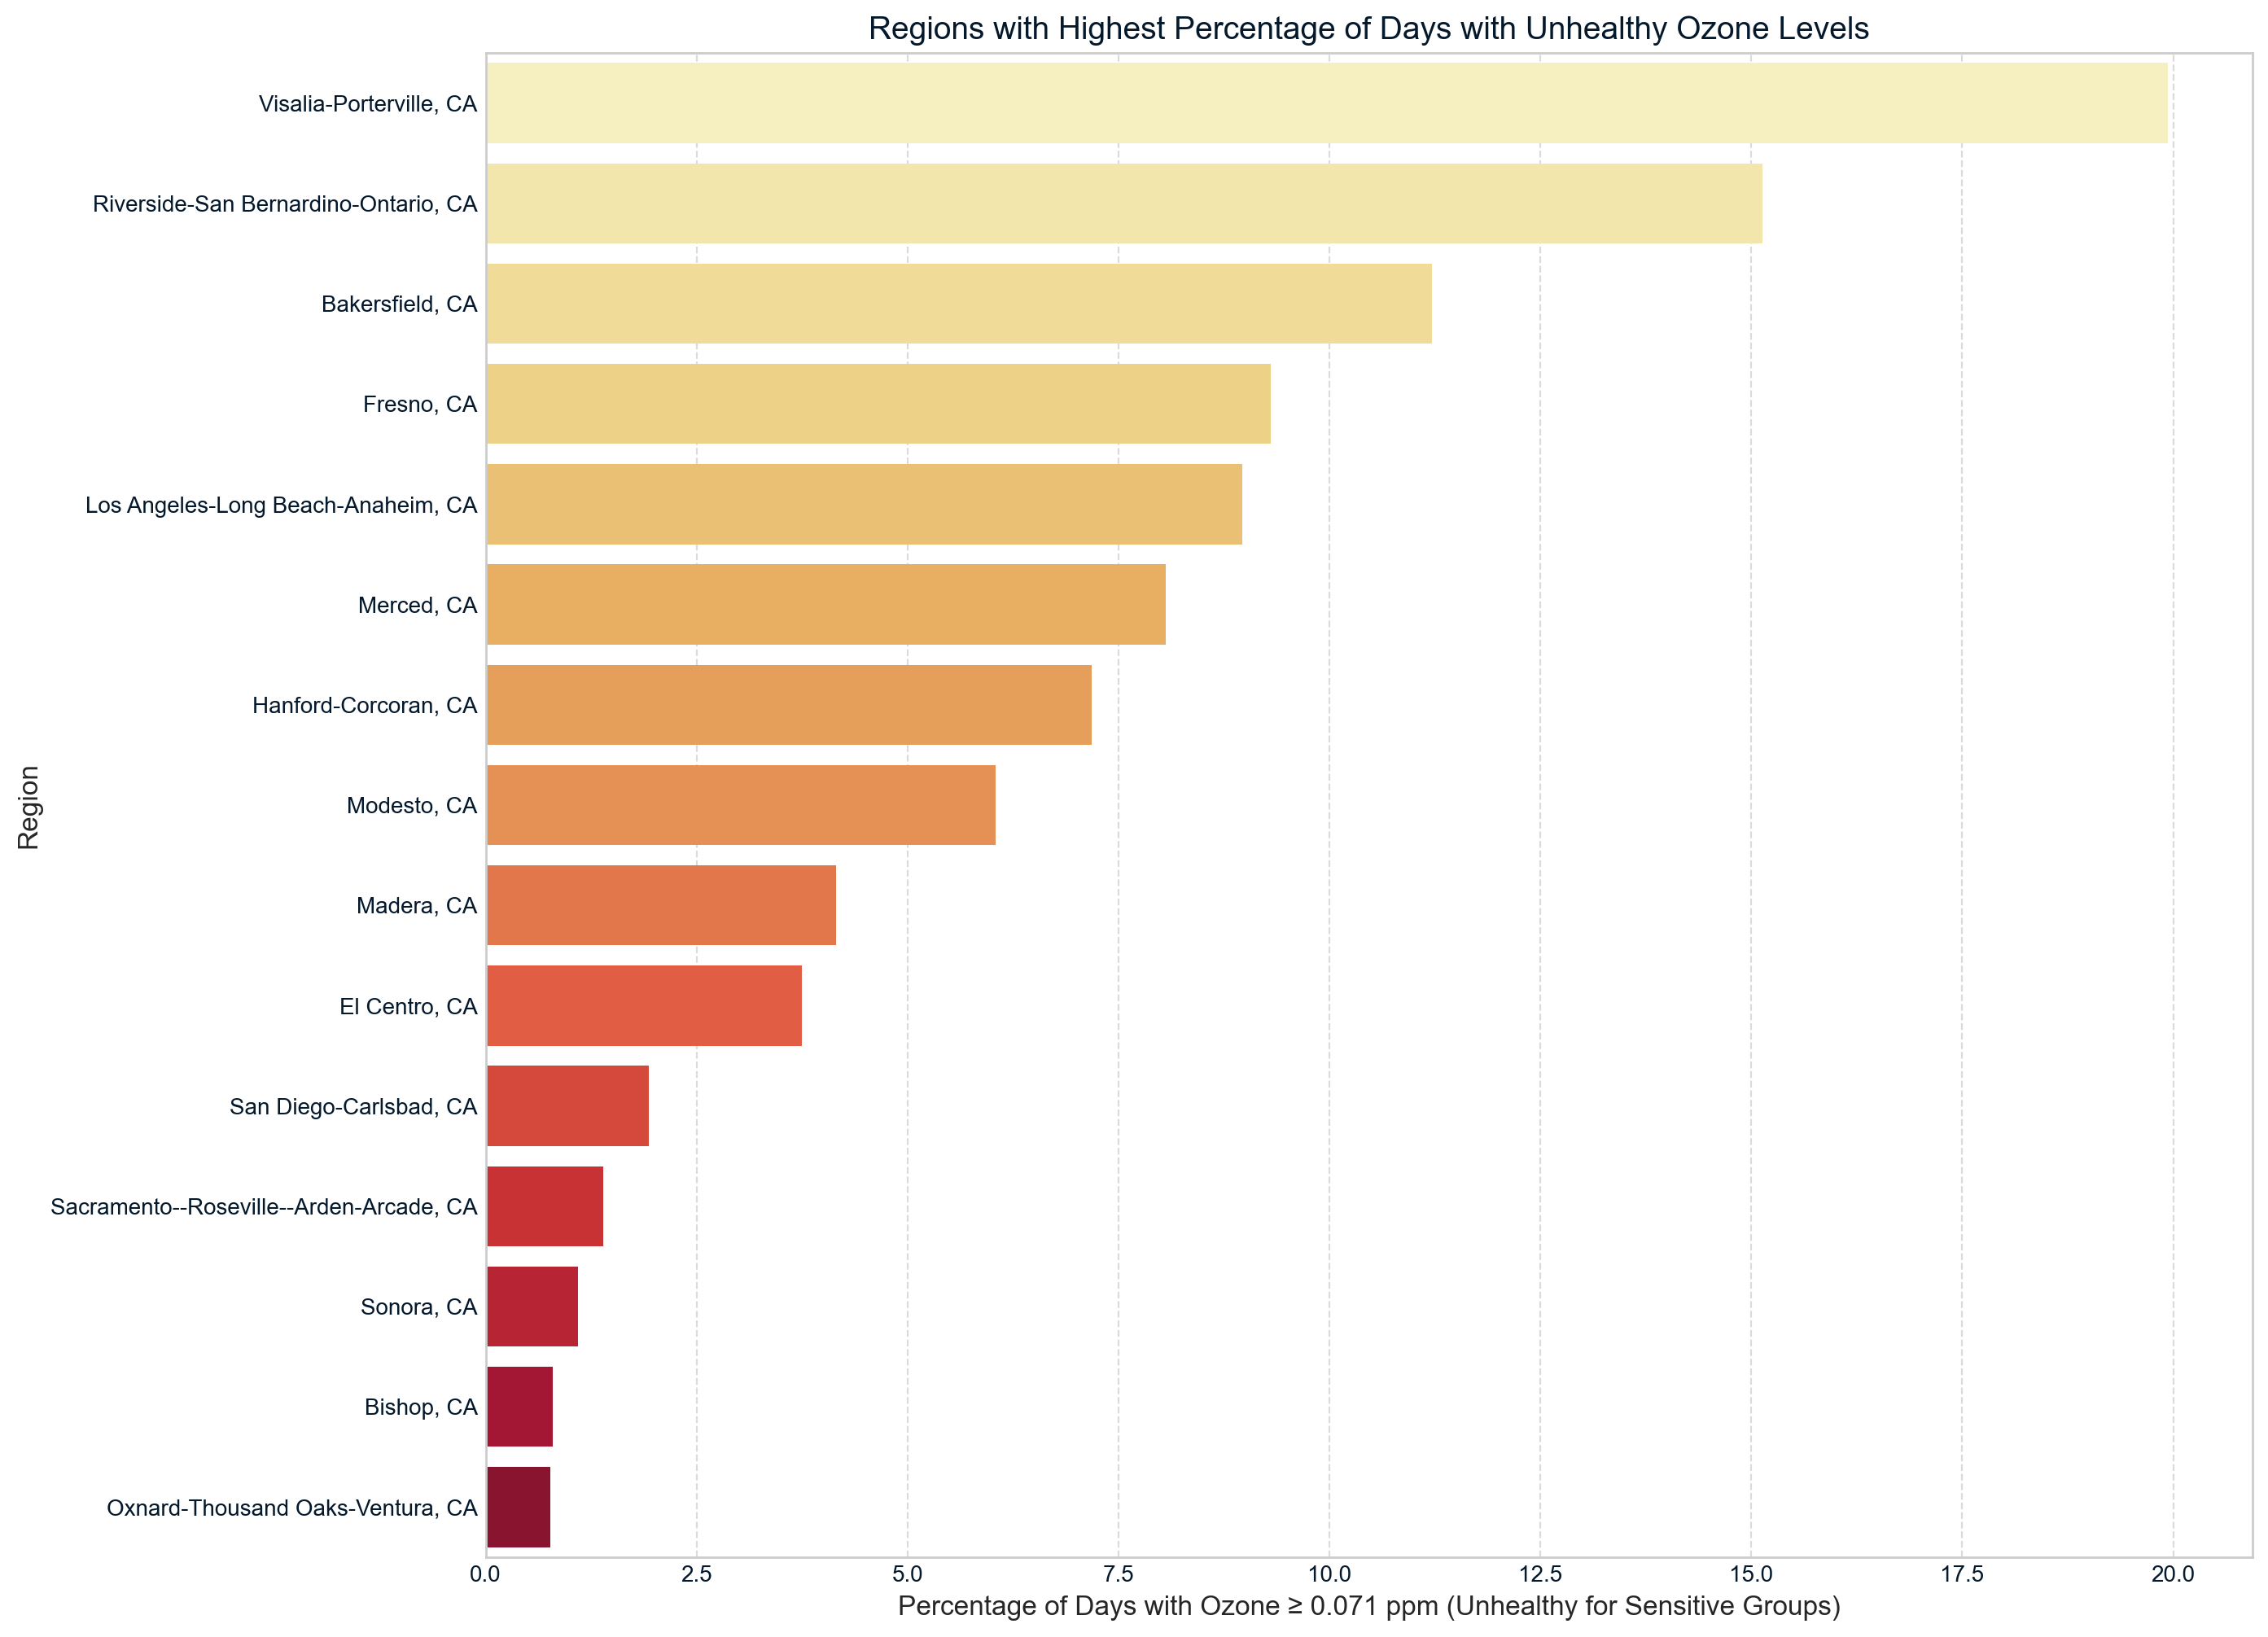

In [ ]:
# Define unhealthy thresholds
ozone_unhealthy_threshold = 0.071  # Unhealthy for Sensitive Groups threshold
aqi_unhealthy_threshold = 101      # Unhealthy for Sensitive Groups threshold

# Group by CBSA Name (region) and calculate:
# 1. Average ozone concentration
# 2. Average AQI value
# 3. Percentage of days with unhealthy ozone levels
# 4. Percentage of days with unhealthy AQI values
region_summary = ozone_reduced.groupby('CBSA Name').agg(
  avg_ozone=('Daily Max 8-hour Ozone Concentration', 'mean'),
  avg_aqi=('Daily AQI Value', 'mean'),
  days_unhealthy_ozone=('Daily Max 8-hour Ozone Concentration', lambda x: (x >= ozone_unhealthy_threshold).mean() * 100),
  days_unhealthy_aqi=('Daily AQI Value', lambda x: (x >= aqi_unhealthy_threshold).mean() * 100),
  count=('Daily Max 8-hour Ozone Concentration', 'count')
).reset_index()

# Sort by percentage of unhealthy days
region_summary = region_summary.sort_values('days_unhealthy_ozone', ascending=False)

# Filter to include only regions with at least 30 days of data and at least some unhealthy days
filtered_regions = region_summary[(region_summary['count'] >= 30) & 
                 (region_summary['days_unhealthy_ozone'] > 0)]

# Select top 15 regions with the highest percentage of unhealthy days
top_regions = filtered_regions.head(15)

# Create a figure with two subplots
fig, ax = plt.subplots(1, 1, figsize=(14, 12))

# Plot the percentage of days with unhealthy ozone levels
sns.barplot(x='days_unhealthy_ozone', y='CBSA Name', data=top_regions, 
      palette='YlOrRd', ax=ax)
ax.set_title('Regions with Highest Percentage of Days with Unhealthy Ozone Levels', fontsize=14)
ax.set_xlabel('Percentage of Days with Ozone ≥ 0.071 ppm (Unhealthy for Sensitive Groups)', fontsize=12)
ax.set_ylabel('Region', fontsize=12)
ax.grid(True, linestyle='--', alpha=0.7, axis='x')

# Print the top 5 most polluted regions with their statistics
print("Top 5 Regions with Highest Percentage of Unhealthy Ozone Days:")
print(top_regions[['CBSA Name', 'avg_ozone', 'avg_aqi', 'days_unhealthy_ozone', 'days_unhealthy_aqi']].head(5).round(2))

### Geo-Spatial Heatmap Analysis

The regional analysis reveals significant geographic disparities in ozone pollution across California. Three distinct air quality regions emerge from our data:

1. **Critical Concern Areas** (>10% unhealthy days):
  - Visalia-Porterville (almost 20% unhealthy days)
  - Riverside-San Bernardino-Ontario (just above 15% unhealthy days)
  - Bakersfield (around 11% unhealthy days)
  
  These inland southern California regions consistently suffer the worst air quality, with nearly 1 in 5 days reaching unhealthy levels in Visalia-Porterville.

2. **Moderate Concern Areas** (5-10% unhealthy days):
  - Fresno (~ 9%)
  - Los Angeles-Long Beach-Anaheim (~ 9%)
  - Merced (~ 8%)
  - Hanford-Corcoran (~ 7%)
  - Modesto (~ 6%)
  
  These Central Valley and greater Los Angeles regions experience unhealthy air roughly once every two weeks during summer months.

3. **Lower Concern Areas** (<2% unhealthy days):
  - Coastal regions (San Diego, San Francisco, Santa Barbara)
  - Northern California (Sacramento, Redding)

The geographic pattern shows that California's worst ozone pollution is concentrated in the Central Valley and Inland Empire regions, where topography (mountain ranges) and climate (hot, sunny conditions) combine with emissions to trap and generate ozone. Coastal regions benefit from marine air and sea breezes that disperse pollutants more effectively.

### Time-Series Analysis for Regions Higher Unhealthy Days

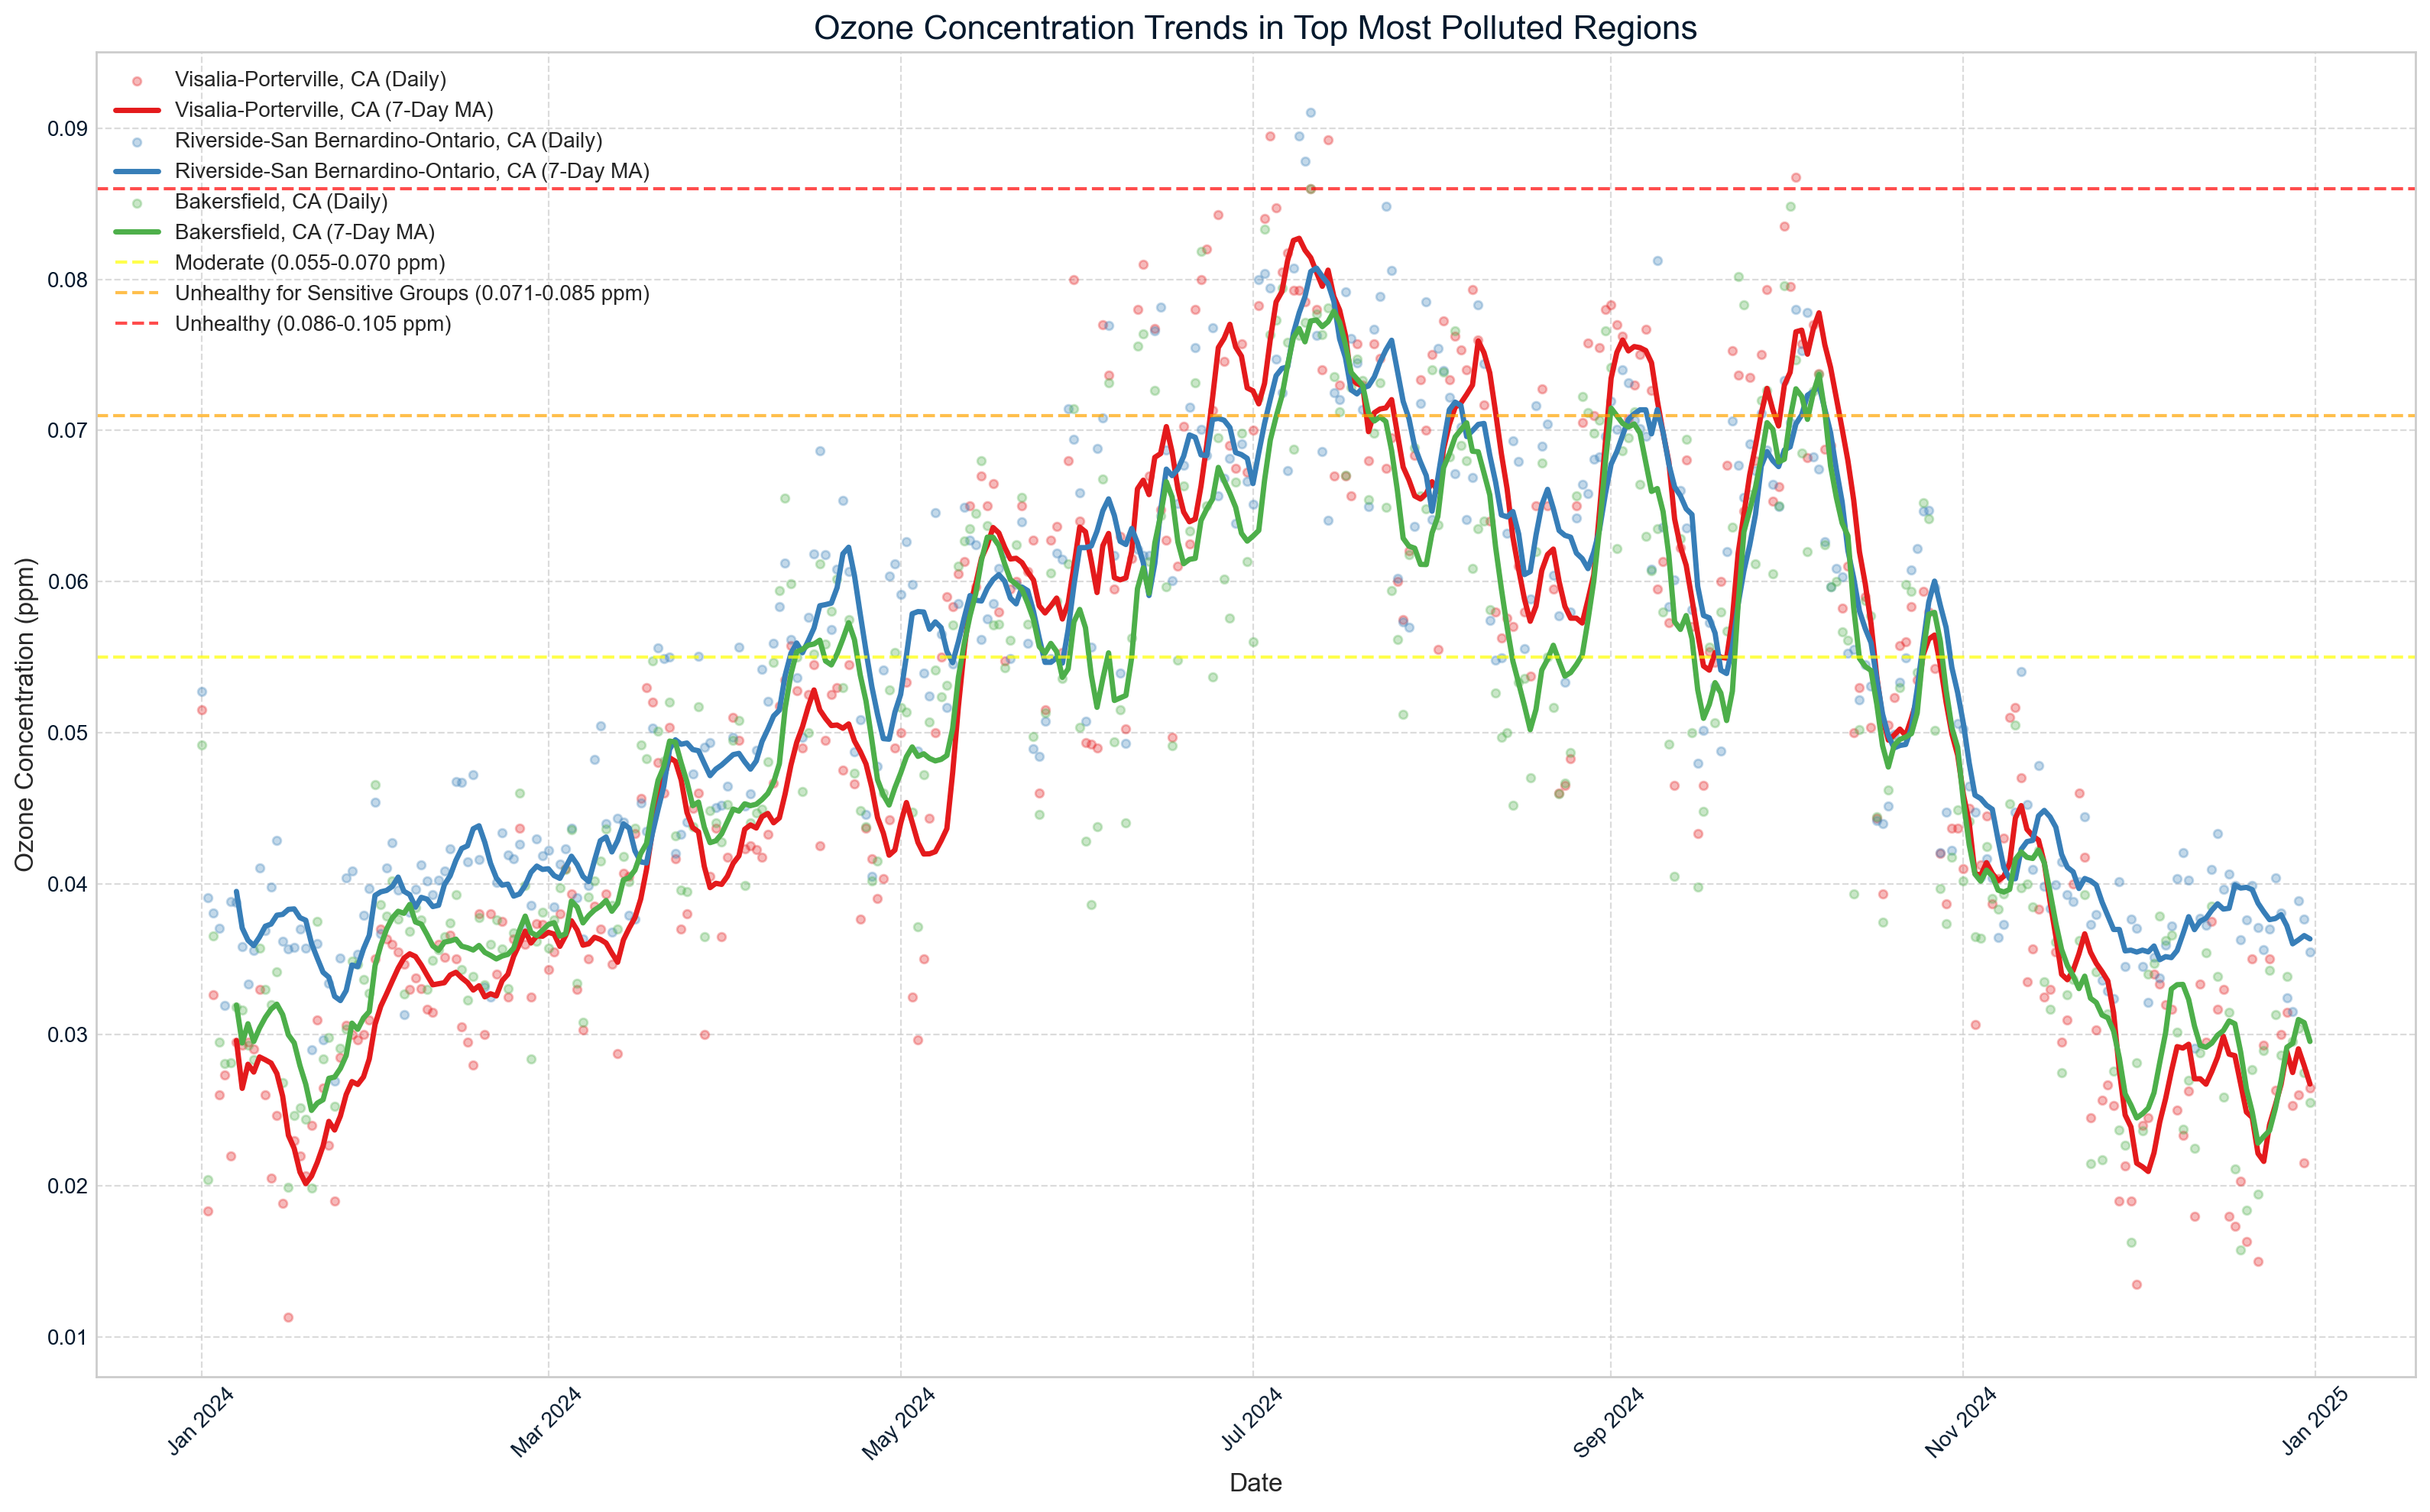

In [ ]:
# Get the top regions with more than 10% unhealthy days
more_than_10_percentage_region = top_regions[top_regions['days_unhealthy_ozone'] > 10]['CBSA Name'].tolist()

# Create a figure
plt.figure(figsize=(16, 10))

# Colours for different regions
colours = ['#e41a1c', '#377eb8', '#4daf4a']

# For each region, plot the time series
for i, region in enumerate(more_than_10_percentage_region):
  # Filter data for this region
  region_data = ozone_reduced[ozone_reduced['CBSA Name'] == region]
  
  # Group by date and calculate mean
  daily_avg = region_data.groupby('Date')['Daily Max 8-hour Ozone Concentration'].mean().reset_index()
  daily_avg = daily_avg.sort_values('Date')
  
  # Calculate 7-day moving average
  daily_avg['7-Day MA'] = daily_avg['Daily Max 8-hour Ozone Concentration'].rolling(window=7, center=False).mean()
  
  # Plot the data
  plt.scatter(daily_avg['Date'], daily_avg['Daily Max 8-hour Ozone Concentration'], 
        alpha=0.3, s=15, color=colours[i], label=f'{region} (Daily)')
  plt.plot(daily_avg['Date'], daily_avg['7-Day MA'], 
       linewidth=2.5, color=colours[i], label=f'{region} (7-Day MA)')

# Add reference lines for EPA standards
plt.axhline(y=0.055, color='yellow', linestyle='--', alpha=0.7, label='Moderate (0.055-0.070 ppm)')
plt.axhline(y=0.071, color='orange', linestyle='--', alpha=0.7, label='Unhealthy for Sensitive Groups (0.071-0.085 ppm)')
plt.axhline(y=0.086, color='red', linestyle='--', alpha=0.7, label='Unhealthy (0.086-0.105 ppm)')

# Customize the plot
plt.title('Ozone Concentration Trends in Top Most Polluted Regions', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Ozone Concentration (ppm)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(loc='upper left', fontsize=10)

# Format x-axis to show months
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%b %Y'))
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

### Regional Comparison of Ozone Concentration Trends

The time series plot shows the daily ozone concentration patterns for California's three most polluted regions over one year. Each region is represented by a distinct colour:

- **Visalia-Porterville** (red): Consistently shows the highest ozone levels throughout summer months
- **Riverside-San Bernardino-Ontario** (blue): Shows slightly lower but still concerning ozone levels
- **Bakersfield** (green): Shows similar patterns to the other regions

Key observations:

- **Seasonal Pattern**: All three regions show a clear seasonal cycle with low winter concentrations (January-March) below 0.04 ppm, steadily rising through spring, and peaking in summer (June-September) when concentrations frequently exceed the "Unhealthy for Sensitive Groups" threshold (orange line at 0.071 ppm).

- **Summer Pollution Crisis**: During July and August, all three regions experience their worst air quality, with Visalia-Porterville and Riverside-San Bernardino regions frequently exceeding not only the "Unhealthy for Sensitive Groups" threshold but occasionally approaching or exceeding the "Unhealthy" threshold (red line at 0.086 ppm).

- **Similar Patterns, Different Magnitudes**: The three regions follow almost identical temporal patterns but with Visalia-Porterville consistently showing the highest concentrations, followed by Riverside-San Bernardino, then Bakersfield, suggesting regional meteorological factors affect all areas similarly.

- **Rapid Fall Improvement**: By October, all regions show a significant improvement as cooler temperatures reduce photochemical ozone formation.

This visualisation confirms that California's Central Valley (Visalia, Bakersfield) and Inland Empire (Riverside-San Bernardino) face the most severe and persistent ozone pollution challenges, particularly during summer months.

## Analysis by Method Code

Method Code Distribution:
Method Code
87.0     35187
47.0      8525
199.0     4047
53.0       391
Name: count, dtype: int64
   Method Code  avg_ozone    avg_aqi  days_unhealthy  count
2         87.0   0.045020  47.525137        5.868645  35187
0         47.0   0.041670  41.077302        2.158358   8525
3        199.0   0.045548  49.697060        7.907092   4047
1         53.0   0.060167  80.304348       35.549872    391


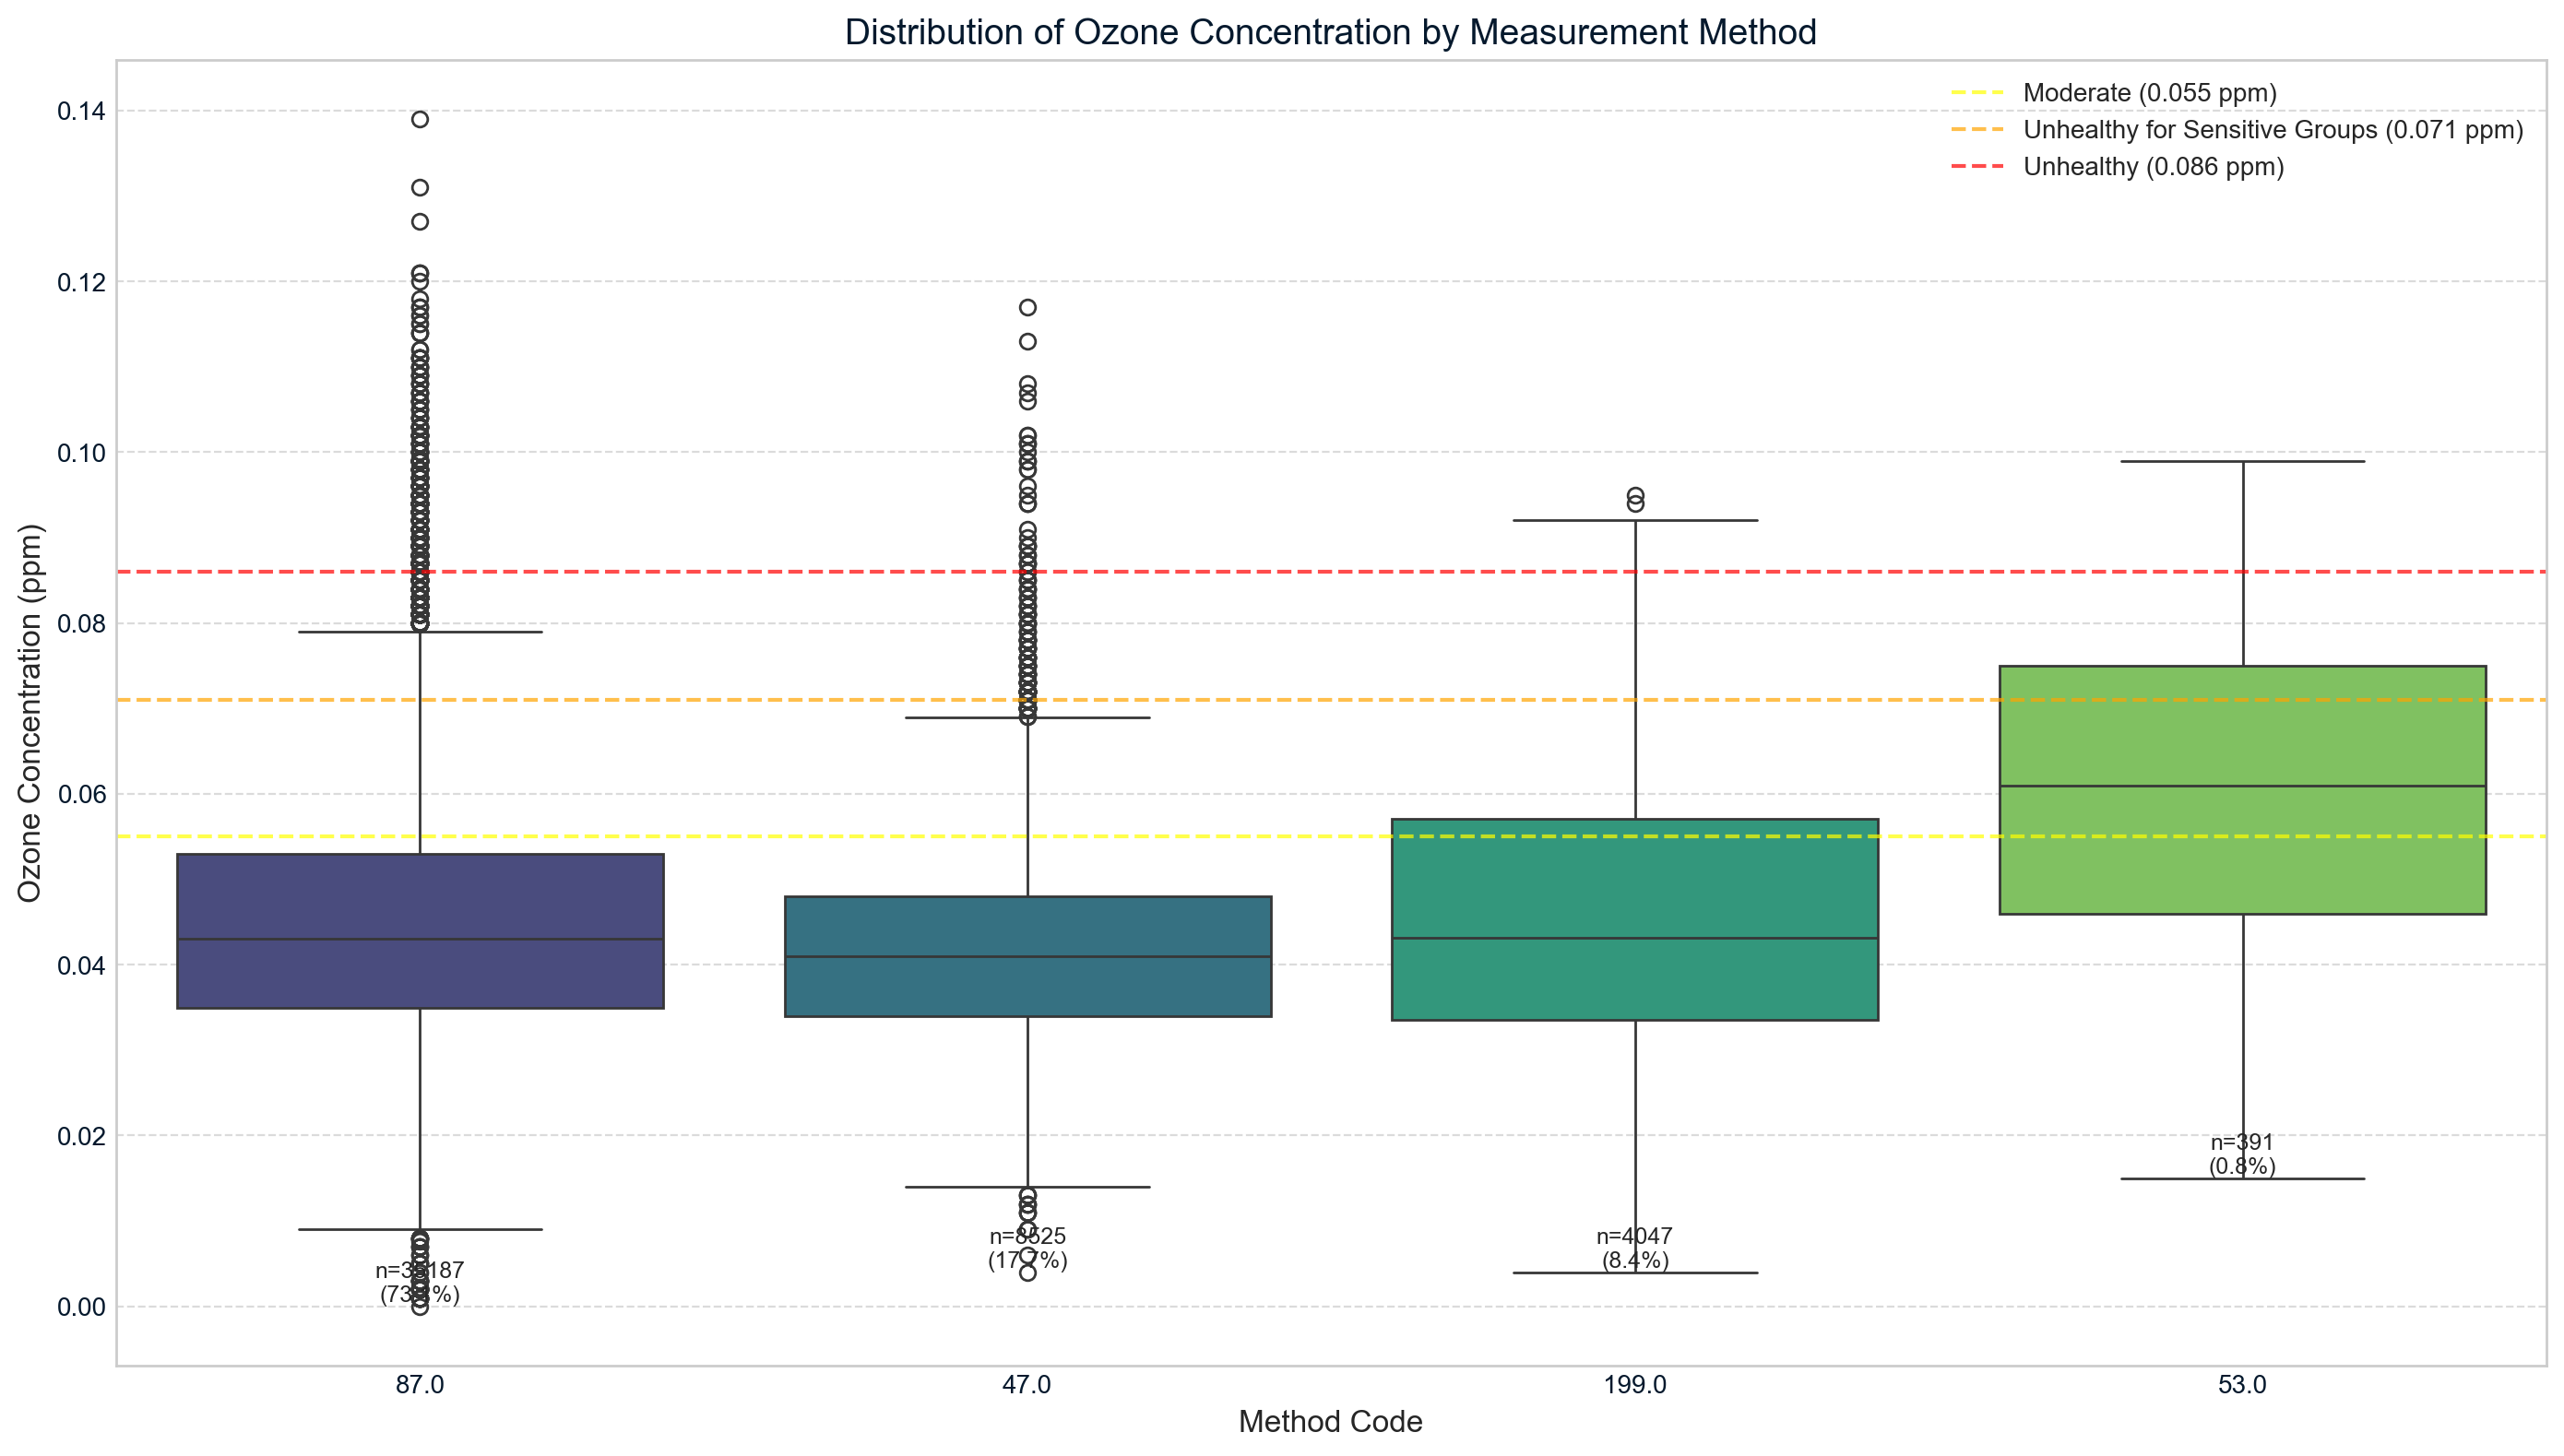

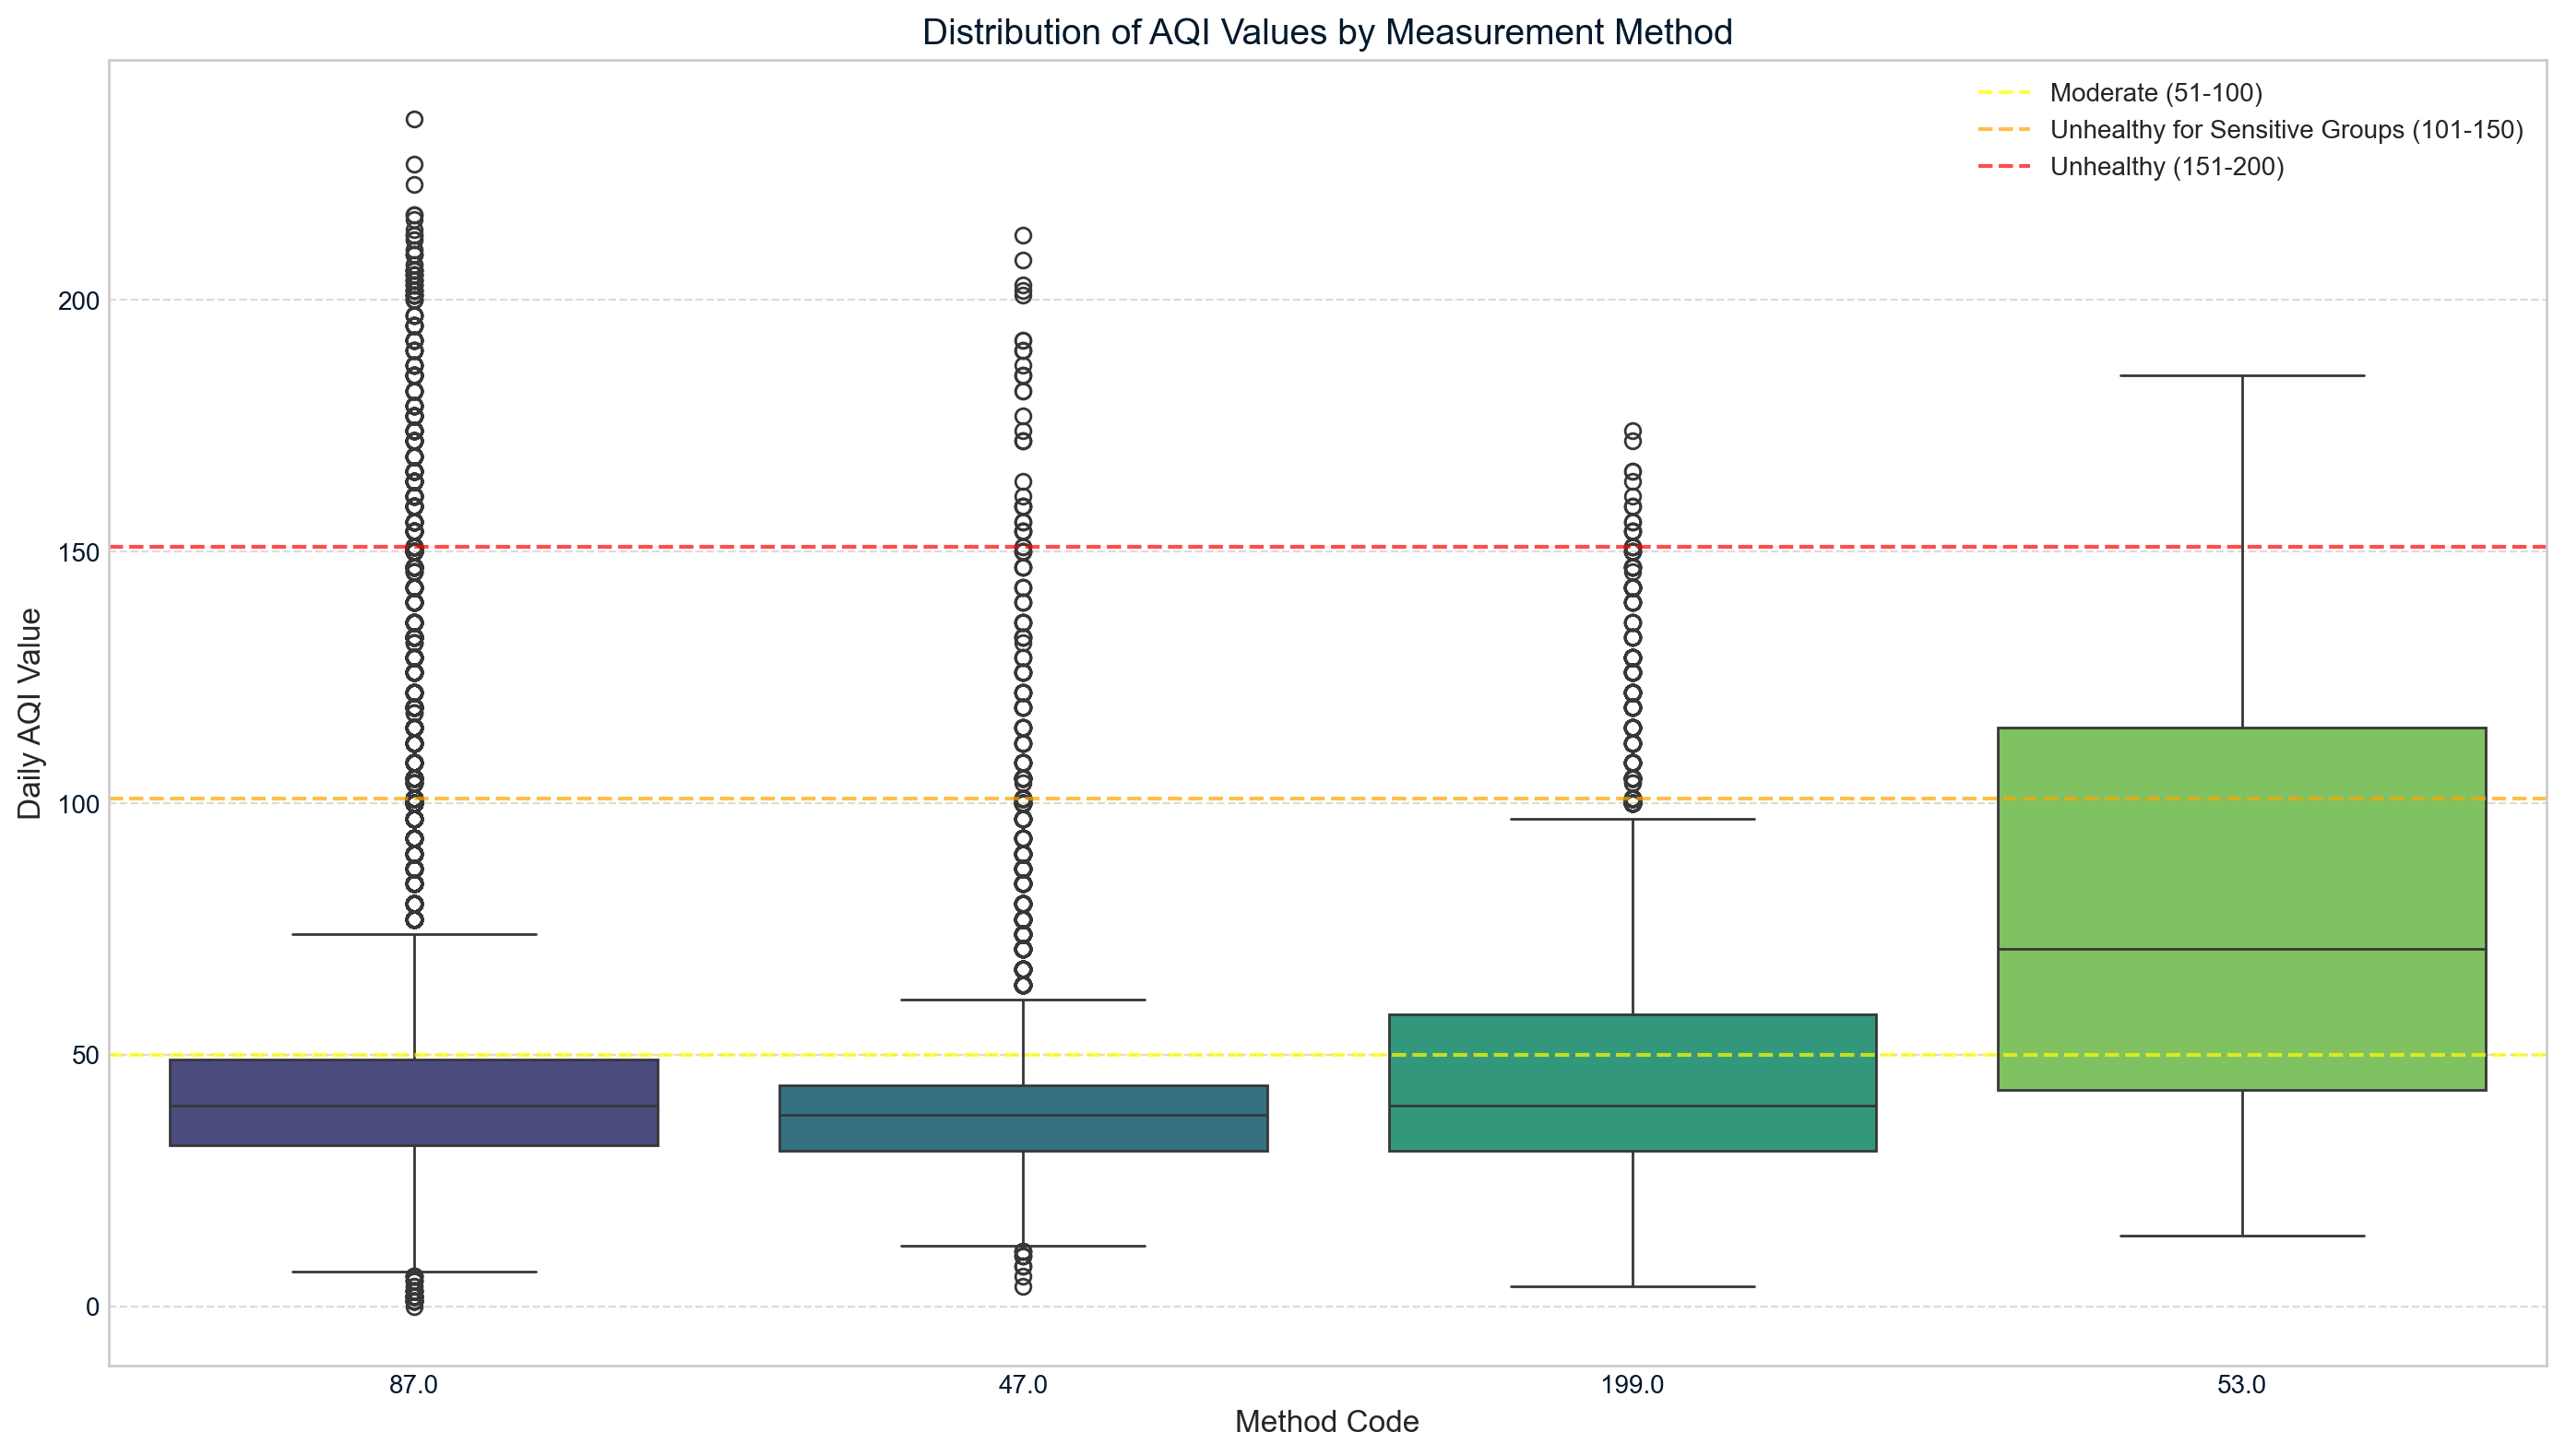

In [ ]:
# First, let's look at the distribution of method codes
method_counts = ozone_reduced['Method Code'].value_counts()
print("Method Code Distribution:")
print(method_counts)

# Let's examine if different methods report different ozone levels
method_comparison = ozone_reduced.groupby('Method Code').agg(
  avg_ozone=('Daily Max 8-hour Ozone Concentration', 'mean'),
  avg_aqi=('Daily AQI Value', 'mean'),
  days_unhealthy=('Daily Max 8-hour Ozone Concentration', lambda x: (x >= 0.071).mean() * 100),
  count=('Daily Max 8-hour Ozone Concentration', 'count')
).reset_index()

# Sort by count for relevance
method_comparison = method_comparison.sort_values('count', ascending=False)
print(method_comparison)

# Create a boxplot to compare distributions of ozone concentration by method
plt.figure(figsize=(14, 8))

# Filter to include only methods with sufficient data (at least 100 measurements)
filtered_methods = method_comparison[method_comparison['count'] >= 100]['Method Code'].tolist()
filtered_data = ozone_reduced[ozone_reduced['Method Code'].isin(filtered_methods)]

# Create boxplot
sns.boxplot(x='Method Code', y='Daily Max 8-hour Ozone Concentration', data=filtered_data, 
           palette='viridis', order=filtered_methods)

# Add sample size annotations
for i, method in enumerate(filtered_methods):
    count = method_counts[method]
    percentage = 100 * count / filtered_data['Method Code'].count()
    plt.annotate(f'n={count}\n({percentage:.1f}%)', 
                xy=(i, filtered_data[filtered_data['Method Code']==method]['Daily Max 8-hour Ozone Concentration'].min()), 
                ha='center', va='bottom', fontsize=9)

# Add reference lines for EPA standards
plt.axhline(y=0.055, color='yellow', linestyle='--', alpha=0.7, label='Moderate (0.055 ppm)')
plt.axhline(y=0.071, color='orange', linestyle='--', alpha=0.7, label='Unhealthy for Sensitive Groups (0.071 ppm)')
plt.axhline(y=0.086, color='red', linestyle='--', alpha=0.7, label='Unhealthy (0.086 ppm)')

plt.title('Distribution of Ozone Concentration by Measurement Method', fontsize=14)
plt.xlabel('Method Code', fontsize=12)
plt.ylabel('Ozone Concentration (ppm)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7, axis='y')
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

# Create a second boxplot to compare distributions of AQI values by method
plt.figure(figsize=(14, 8))

# Create boxplot for AQI
sns.boxplot(x='Method Code', y='Daily AQI Value', data=filtered_data, 
           palette='viridis', order=filtered_methods)

# Add reference lines for AQI thresholds
plt.axhline(y=50, color='yellow', linestyle='--', alpha=0.7, label='Moderate (51-100)')
plt.axhline(y=101, color='orange', linestyle='--', alpha=0.7, label='Unhealthy for Sensitive Groups (101-150)')
plt.axhline(y=151, color='red', linestyle='--', alpha=0.7, label='Unhealthy (151-200)')

plt.title('Distribution of AQI Values by Measurement Method', fontsize=14)
plt.xlabel('Method Code', fontsize=12)
plt.ylabel('Daily AQI Value', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7, axis='y')
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()


### Method Comparison Analysis

Four primary measurement methods are used across California's monitoring network:
- **Method 87** (35,187 records): The most widely used method, showing moderate ozone readings (avg 0.045 ppm)
- **Method 47** (8,525 records): Reports the lowest average concentrations (0.042 ppm)
- **Method 199** (4,047 records): Shows slightly higher readings (0.046 ppm)
- **Method 53** (391 records): Reports significantly higher concentrations (0.060 ppm) with 35.5% of readings in unhealthy ranges

### Key Observations

1. **Methodological Bias**: Method 53, though used at few sites, consistently reports higher ozone concentrations than other methods. This suggests either:
  - It's deployed in particularly polluted locations
  - It has different calibration or higher sensitivity
  - It uses a different measurement technology

2. **Distribution Patterns**: 
  - Methods 87, 47, and 199 show relatively similar distributions with occasional high outliers
  - Method 53's distribution is notably shifted upward, with its median higher than the other methods' 75th percentiles

3. **Implications for Data Interpretation**: The significant differences between methods highlight the importance of accounting for measurement methodology when comparing regions or time periods.

The corresponding AQI value boxplot confirms these patterns, showing that Method 53 reports consistently higher AQI values (average 80.3) compared to other methods (ranging from 41.1 to 49.7), crossing into the "Moderate" air quality category more frequently.

## Weekdays vs Weekends

<Figure size 1600x1000 with 0 Axes>

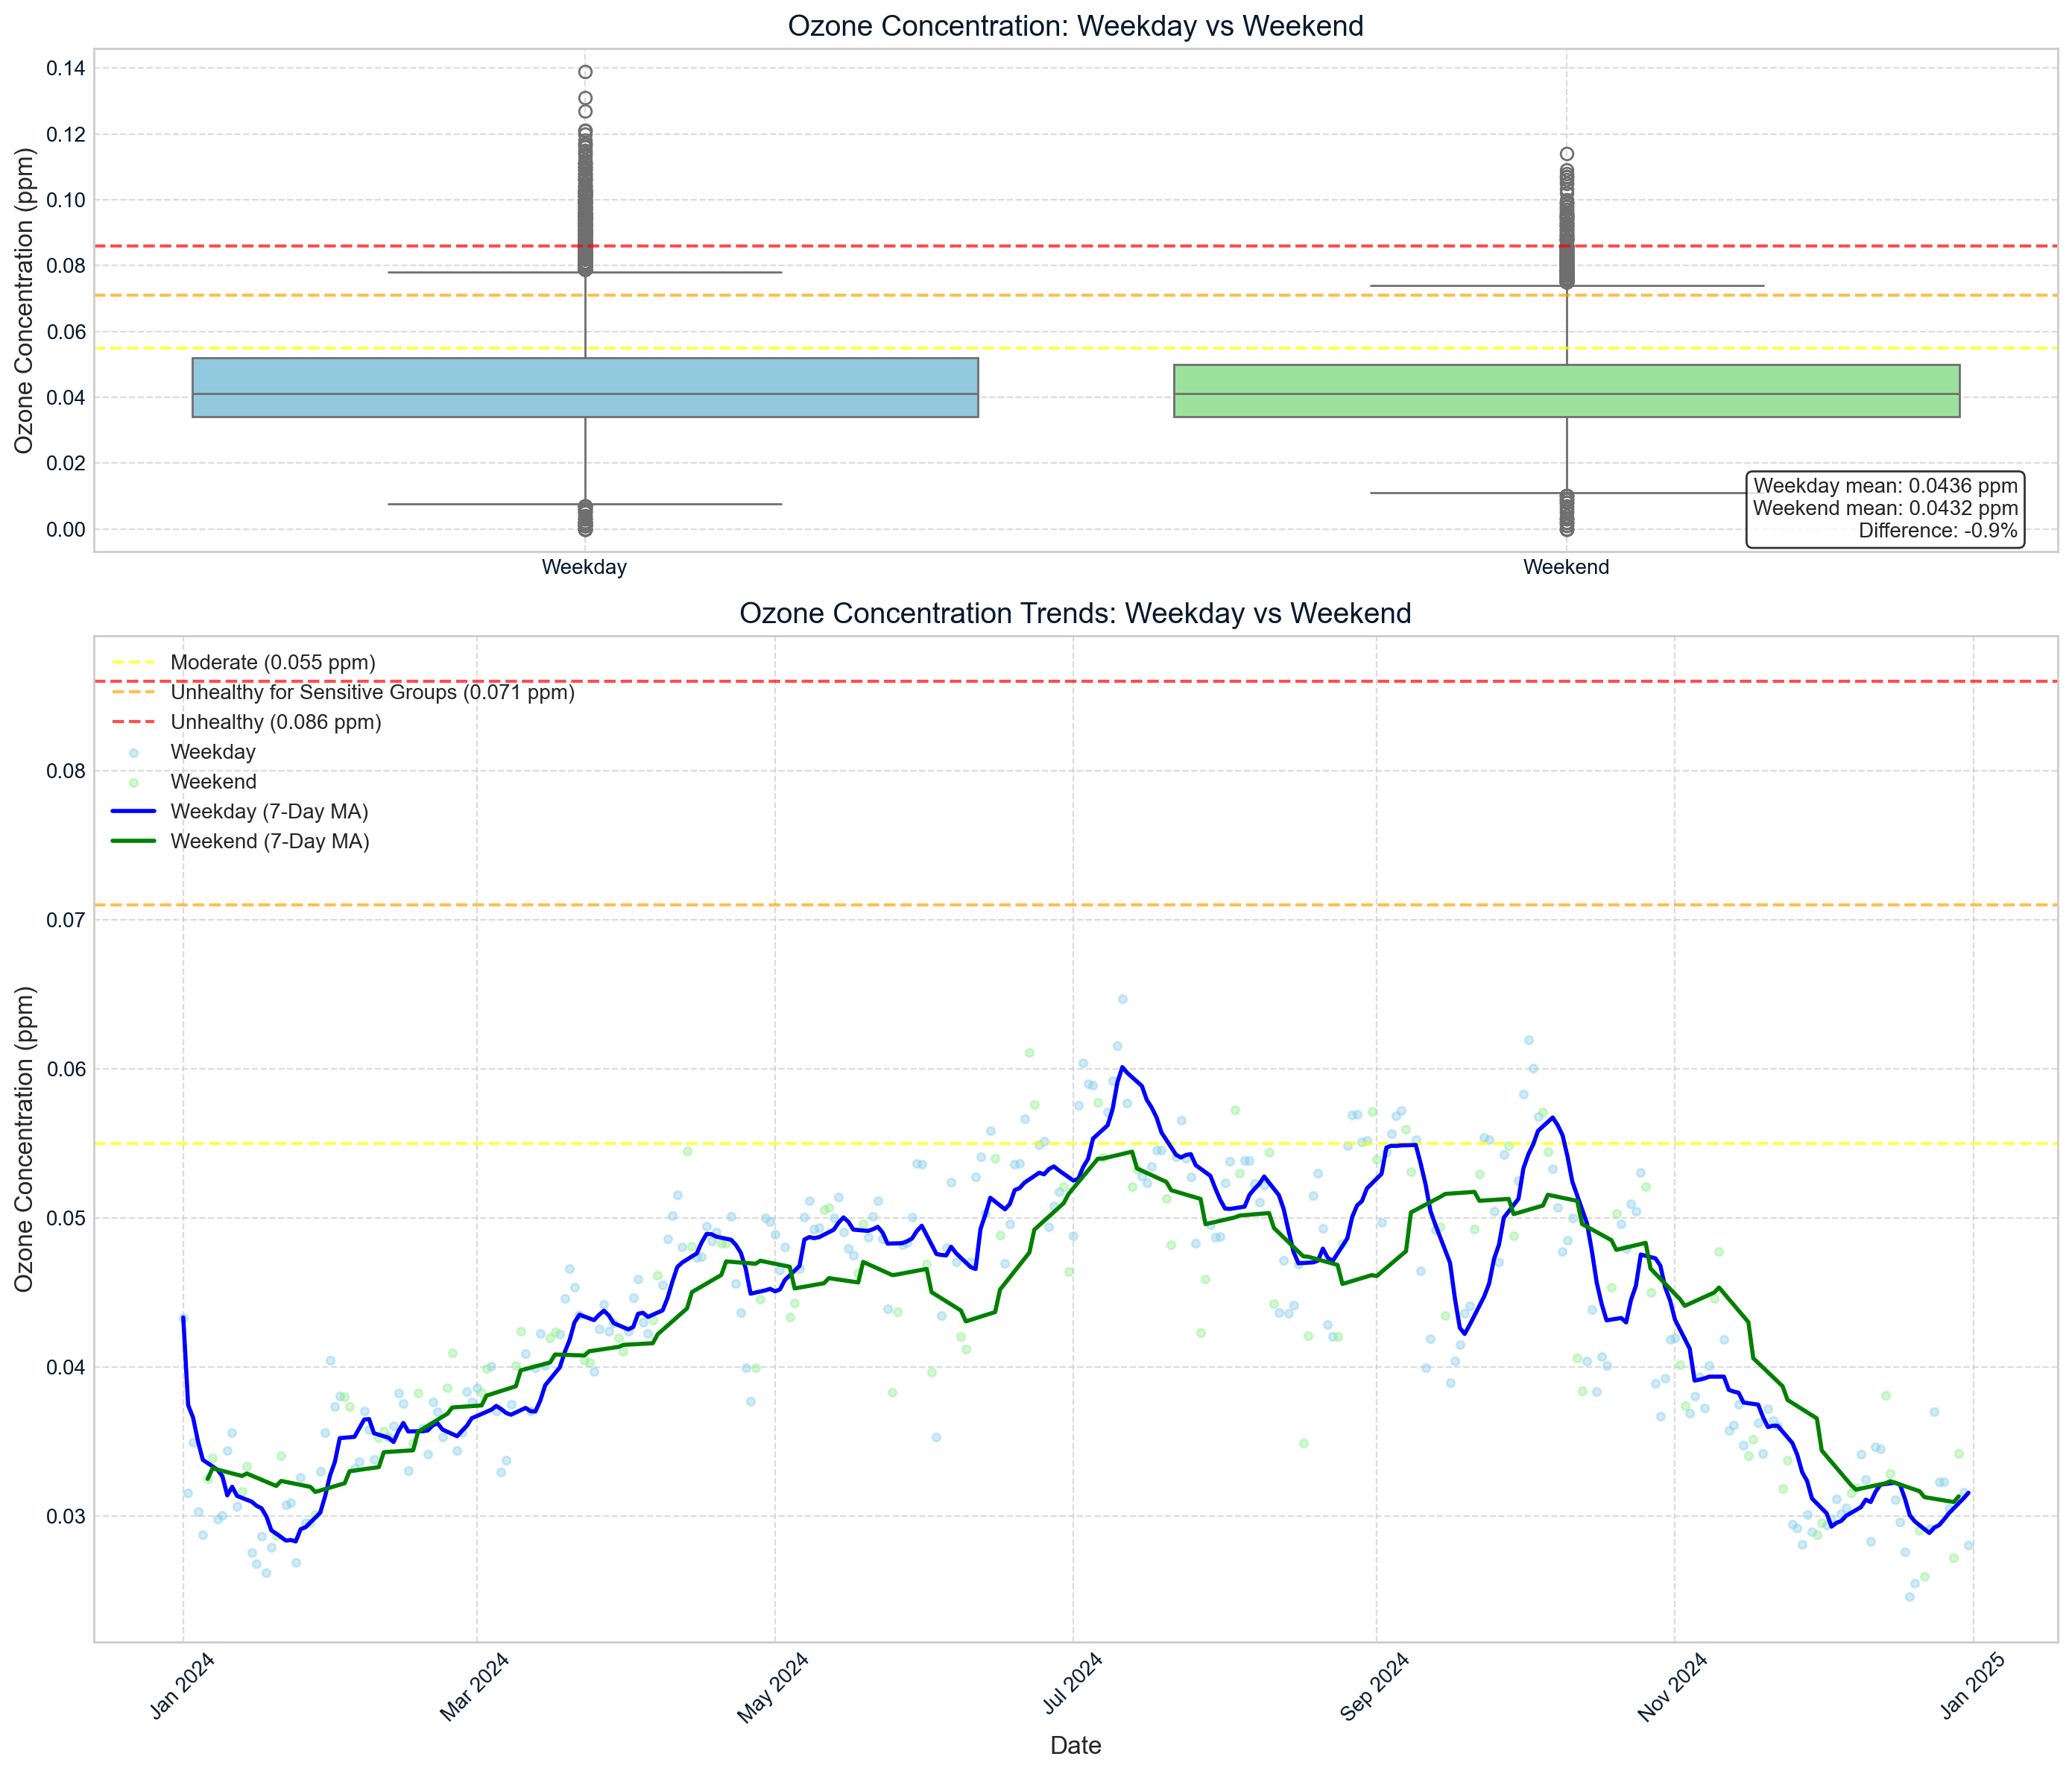

In [ ]:
# Create a column for weekday names for better readability
ozone_reduced['DayOfWeek'] = ozone_reduced['Date'].dt.day_name()

# Create a figure to compare weekday vs weekend ozone concentrations
plt.figure(figsize=(16, 10))

# Create subplots - 1 for overall comparison, 1 for time series
fig, axes = plt.subplots(2, 1, figsize=(14, 12), gridspec_kw={'height_ratios': [1, 2]})

# Plot 1: Overall boxplot comparison of weekday vs weekend
sns.boxplot(x='IsWeekend', y='Daily Max 8-hour Ozone Concentration', 
       data=ozone_reduced, 
       palette=['skyblue', 'lightgreen'],
       ax=axes[0])

# Add labels and customize
axes[0].set_title('Ozone Concentration: Weekday vs Weekend', fontsize=14)
axes[0].set_xlabel('')
axes[0].set_ylabel('Ozone Concentration (ppm)', fontsize=12)
axes[0].set_xticklabels(['Weekday', 'Weekend'])
axes[0].grid(True, linestyle='--', alpha=0.7)

# Add reference lines for EPA standards
for ax in axes:
  ax.axhline(y=0.055, color='yellow', linestyle='--', alpha=0.7, label='Moderate (0.055 ppm)')
  ax.axhline(y=0.071, color='orange', linestyle='--', alpha=0.7, label='Unhealthy for Sensitive Groups (0.071 ppm)')
  ax.axhline(y=0.086, color='red', linestyle='--', alpha=0.7, label='Unhealthy (0.086 ppm)')

# Add statistical information
weekday_mean = ozone_reduced[~ozone_reduced['IsWeekend']]['Daily Max 8-hour Ozone Concentration'].mean()
weekend_mean = ozone_reduced[ozone_reduced['IsWeekend']]['Daily Max 8-hour Ozone Concentration'].mean()
diff_pct = ((weekend_mean - weekday_mean) / weekday_mean) * 100

axes[0].annotate(f'Weekday mean: {weekday_mean:.4f} ppm\nWeekend mean: {weekend_mean:.4f} ppm\nDifference: {diff_pct:.1f}%',
        xy=(0.98, 0.02), xycoords='axes fraction', 
        ha='right', va='bottom', fontsize=10,
        bbox=dict(boxstyle='round', fc='white', alpha=0.8))

# Plot 2: Time series with weekday/weekend separation
# Group by date and IsWeekend, and calculate mean
daily_avg = ozone_reduced.groupby(['Date', 'IsWeekend'])['Daily Max 8-hour Ozone Concentration'].mean().reset_index()

# Plot weekday data
weekday_data = daily_avg[~daily_avg['IsWeekend']]
axes[1].scatter(weekday_data['Date'], weekday_data['Daily Max 8-hour Ozone Concentration'], 
       alpha=0.4, s=15, color='skyblue', label='Weekday')

# Plot weekend data
weekend_data = daily_avg[daily_avg['IsWeekend']]
axes[1].scatter(weekend_data['Date'], weekend_data['Daily Max 8-hour Ozone Concentration'], 
       alpha=0.4, s=15, color='lightgreen', label='Weekend')

# Calculate and plot 7-day moving averages for better trend visibility
# First, create a copy of daily_avg sorted by date
sorted_data = daily_avg.sort_values('Date')

# Calculate 7-day moving average for weekdays and weekends
weekday_ma = sorted_data[~sorted_data['IsWeekend']].set_index('Date')['Daily Max 8-hour Ozone Concentration'].rolling(window=7, min_periods=1).mean()
weekend_ma = sorted_data[sorted_data['IsWeekend']].set_index('Date')['Daily Max 8-hour Ozone Concentration'].rolling(window=7, min_periods=1).mean()

# Plot the moving averages
axes[1].plot(weekday_ma.index, weekday_ma.values, linewidth=2, color='blue', label='Weekday (7-Day MA)')
axes[1].plot(weekend_ma.index, weekend_ma.values, linewidth=2, color='green', label='Weekend (7-Day MA)')

# Customize the time series plot
axes[1].set_title('Ozone Concentration Trends: Weekday vs Weekend', fontsize=14)
axes[1].set_xlabel('Date', fontsize=12)
axes[1].set_ylabel('Ozone Concentration (ppm)', fontsize=12)
axes[1].grid(True, linestyle='--', alpha=0.7)
axes[1].legend(loc='upper left')

# Format x-axis to show months
axes[1].xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%b %Y'))
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

The analysis of ozone concentrations by day type reveals important patterns about human activity's impact on air quality in California:

### Overall Comparison
- **Minimal Difference**: Weekend ozone concentrations (0.0432 ppm) are only slightly lower than weekday levels (0.0436 ppm), showing a difference of just -0.87%.
- **Similar Distributions**: The boxplot shows nearly identical distributions between weekdays and weekends, with similar medians, quartiles, and outlier patterns.

### Seasonal Patterns
- Both weekday and weekend concentrations follow identical seasonal cycles:
  - Winter months (January-March): Low concentrations (~0.030-0.035 ppm)
  - Spring (April-May): Gradual increase
  - Summer (June-September): Peak ozone levels (~0.055-0.060 ppm)
  - Fall (October-December): Steady decline

### Key Findings
1. **Weekend Effect**: Unlike many urban areas globally that show significant "weekend effects" with reduced pollution, California's ozone patterns show minimal weekend reductions.

2. **Meteorological Dominance**: The consistent seasonal pattern regardless of day type suggests that meteorological factors (temperature, sunlight, atmospheric conditions) might have a stronger influence on ozone formation than daily variations in human activity.

3. **Complex Chemistry**: The absence of a strong weekend effect may reflect California's complex atmospheric chemistry, where reduced NOx emissions on weekends can sometimes lead to increased ozone formation due to VOC-limited conditions.

The data indicates that California's ozone pollution is primarily driven by regional meteorological factors and accumulated emissions rather than day-to-day variations in activity patterns.

## Geo-Spatial Visualisation

In [ ]:
# First, let's download California county shapefile data
def download_california_shapefile():
    """Download California county shapefile from US Census Bureau"""
    url = "https://www2.census.gov/geo/tiger/GENZ2020/shp/cb_2020_us_county_20m.zip"
    
    # Create data directory if it doesn't exist
    data_dir = Path.cwd() / 'data'
    shapefile_dir = data_dir / 'shapefiles'
    shapefile_dir.mkdir(parents=True, exist_ok=True)
    
    shapefile_path = shapefile_dir / 'california_counties.shp'
    
    # Check if shapefile already exists
    if shapefile_path.exists():
        print("Shapefile already exists, loading...")
        return shapefile_path
    
    print("Downloading US counties shapefile...")
    response = requests.get(url)
    
    if response.status_code == 200:
        print("Extracting shapefile...")
        with zipfile.ZipFile(BytesIO(response.content)) as zip_file:
            zip_file.extractall(shapefile_dir)
        
        # Find the .shp file
        for file in shapefile_dir.glob('*.shp'):
            if 'county' in file.name.lower():
                return file
    else:
        print(f"Failed to download shapefile. Status code: {response.status_code}")
        return None

# Download and load the shapefile
shapefile_path = download_california_shapefile()

if shapefile_path:
    # Read the US counties shapefile and filter for California
    us_counties = gpd.read_file(shapefile_path)
    
    # Filter for California counties (STATEFP = '06' for California)
    ca_counties = us_counties[us_counties['STATEFP'] == '06'].copy()
    
    print(f"Loaded {len(ca_counties)} California counties")
    print("Sample counties:", ca_counties['NAME'].head().tolist())
else:
    print("Could not load shapefile, using alternative approach...")
    ca_counties = None

Extracting shapefile...
Loaded 58 California counties
Sample counties: ['Stanislaus', 'San Benito', 'Nevada', 'Kings', 'Glenn']


In [ ]:
# Prepare data for geospatial visualisation
print("Preparing ozone concentration data for mapping...")

# Calculate average ozone concentration by monitoring site
site_summary = ozone_reduced.groupby(['Local Site Name', 'County', 'Site Latitude', 'Site Longitude']).agg({
    'Daily Max 8-hour Ozone Concentration': ['mean', 'max', 'count'],
    'Daily AQI Value': ['mean', 'max'],
    'Date': ['min', 'max']
}).reset_index()

# Flatten column names
site_summary.columns = ['Site_Name', 'County', 'Latitude', 'Longitude', 
                       'Avg_Ozone', 'Max_Ozone', 'Count', 'Avg_AQI', 'Max_AQI', 'Start_Date', 'End_Date']

# Filter sites with sufficient data (at least 30 measurements)
site_summary_filtered = site_summary[site_summary['Count'] >= 30].copy()

print(f"Total monitoring sites: {len(site_summary)}")
print(f"Sites with sufficient data (≥30 measurements): {len(site_summary_filtered)}")

# Create categories for visualisation
def categorize_ozone(concentration):
    """Categorize ozone concentration according to EPA standards"""
    if concentration < 0.055:
        return 'Good'
    elif concentration < 0.071:
        return 'Moderate'
    elif concentration < 0.086:
        return 'Unhealthy for Sensitive Groups'
    elif concentration < 0.106:
        return 'Unhealthy'
    else:
        return 'Very Unhealthy'

def get_color_for_ozone(concentration):
    """Get color code for ozone concentration levels"""
    if concentration < 0.055:
        return '#00e400'  # Green - Good
    elif concentration < 0.071:
        return '#ffff00'  # Yellow - Moderate
    elif concentration < 0.086:
        return '#ff7e00'  # Orange - Unhealthy for Sensitive Groups
    elif concentration < 0.106:
        return '#ff0000'  # Red - Unhealthy
    else:
        return '#8f3f97'  # Purple - Very Unhealthy

# Apply categorization
site_summary_filtered['Ozone_Category'] = site_summary_filtered['Avg_Ozone'].apply(categorize_ozone)
site_summary_filtered['Color'] = site_summary_filtered['Avg_Ozone'].apply(get_color_for_ozone)

print("\nOzone concentration categories:")
print(site_summary_filtered['Ozone_Category'].value_counts())

# Display top 5 most polluted sites
top_polluted_sites = site_summary_filtered.nlargest(5, 'Avg_Ozone')
print("\nTop 5 most polluted monitoring sites:")
print(top_polluted_sites[['Site_Name', 'County', 'Avg_Ozone', 'Ozone_Category']].round(4))

Preparing ozone concentration data for mapping...
Total monitoring sites: 174
Sites with sufficient data (≥30 measurements): 160

Ozone concentration categories:
Ozone_Category
Good        150
Moderate     10
Name: count, dtype: int64

Top 5 most polluted monitoring sites:
                                     Site_Name  ... Ozone_Category
140  Sequoia & Kings Canyon NPs - Lower Kaweah  ...       Moderate
27                                   Crestline  ...       Moderate
113                                   Redlands  ...       Moderate
83              Morongo Air Monitoring Station  ...       Moderate
123                             San Bernardino  ...       Moderate

[5 rows x 4 columns]


County-level Ozone Analysis:
Counties with sufficient data (≥100 measurements): 48

Top 10 Counties by Average Ozone Concentration:
            County  Avg_Ozone  Max_Ozone  Avg_AQI  Count
30  San Bernardino     0.0553      0.131  68.2918   3235
26       Riverside     0.0522      0.117  59.4315   3935
46          Tulare     0.0520      0.099  63.4095   1304
10        Imperial     0.0498      0.139  52.2812   1202
12            Kern     0.0492      0.096  55.7288   2872
16     Los Angeles     0.0485      0.114  53.9234   4271
19        Mariposa     0.0483      0.080  47.7113    582
6        El Dorado     0.0477      0.075  47.7059    765
21          Merced     0.0464      0.086  50.4946    372
7           Fresno     0.0459      0.093  50.5258   2537


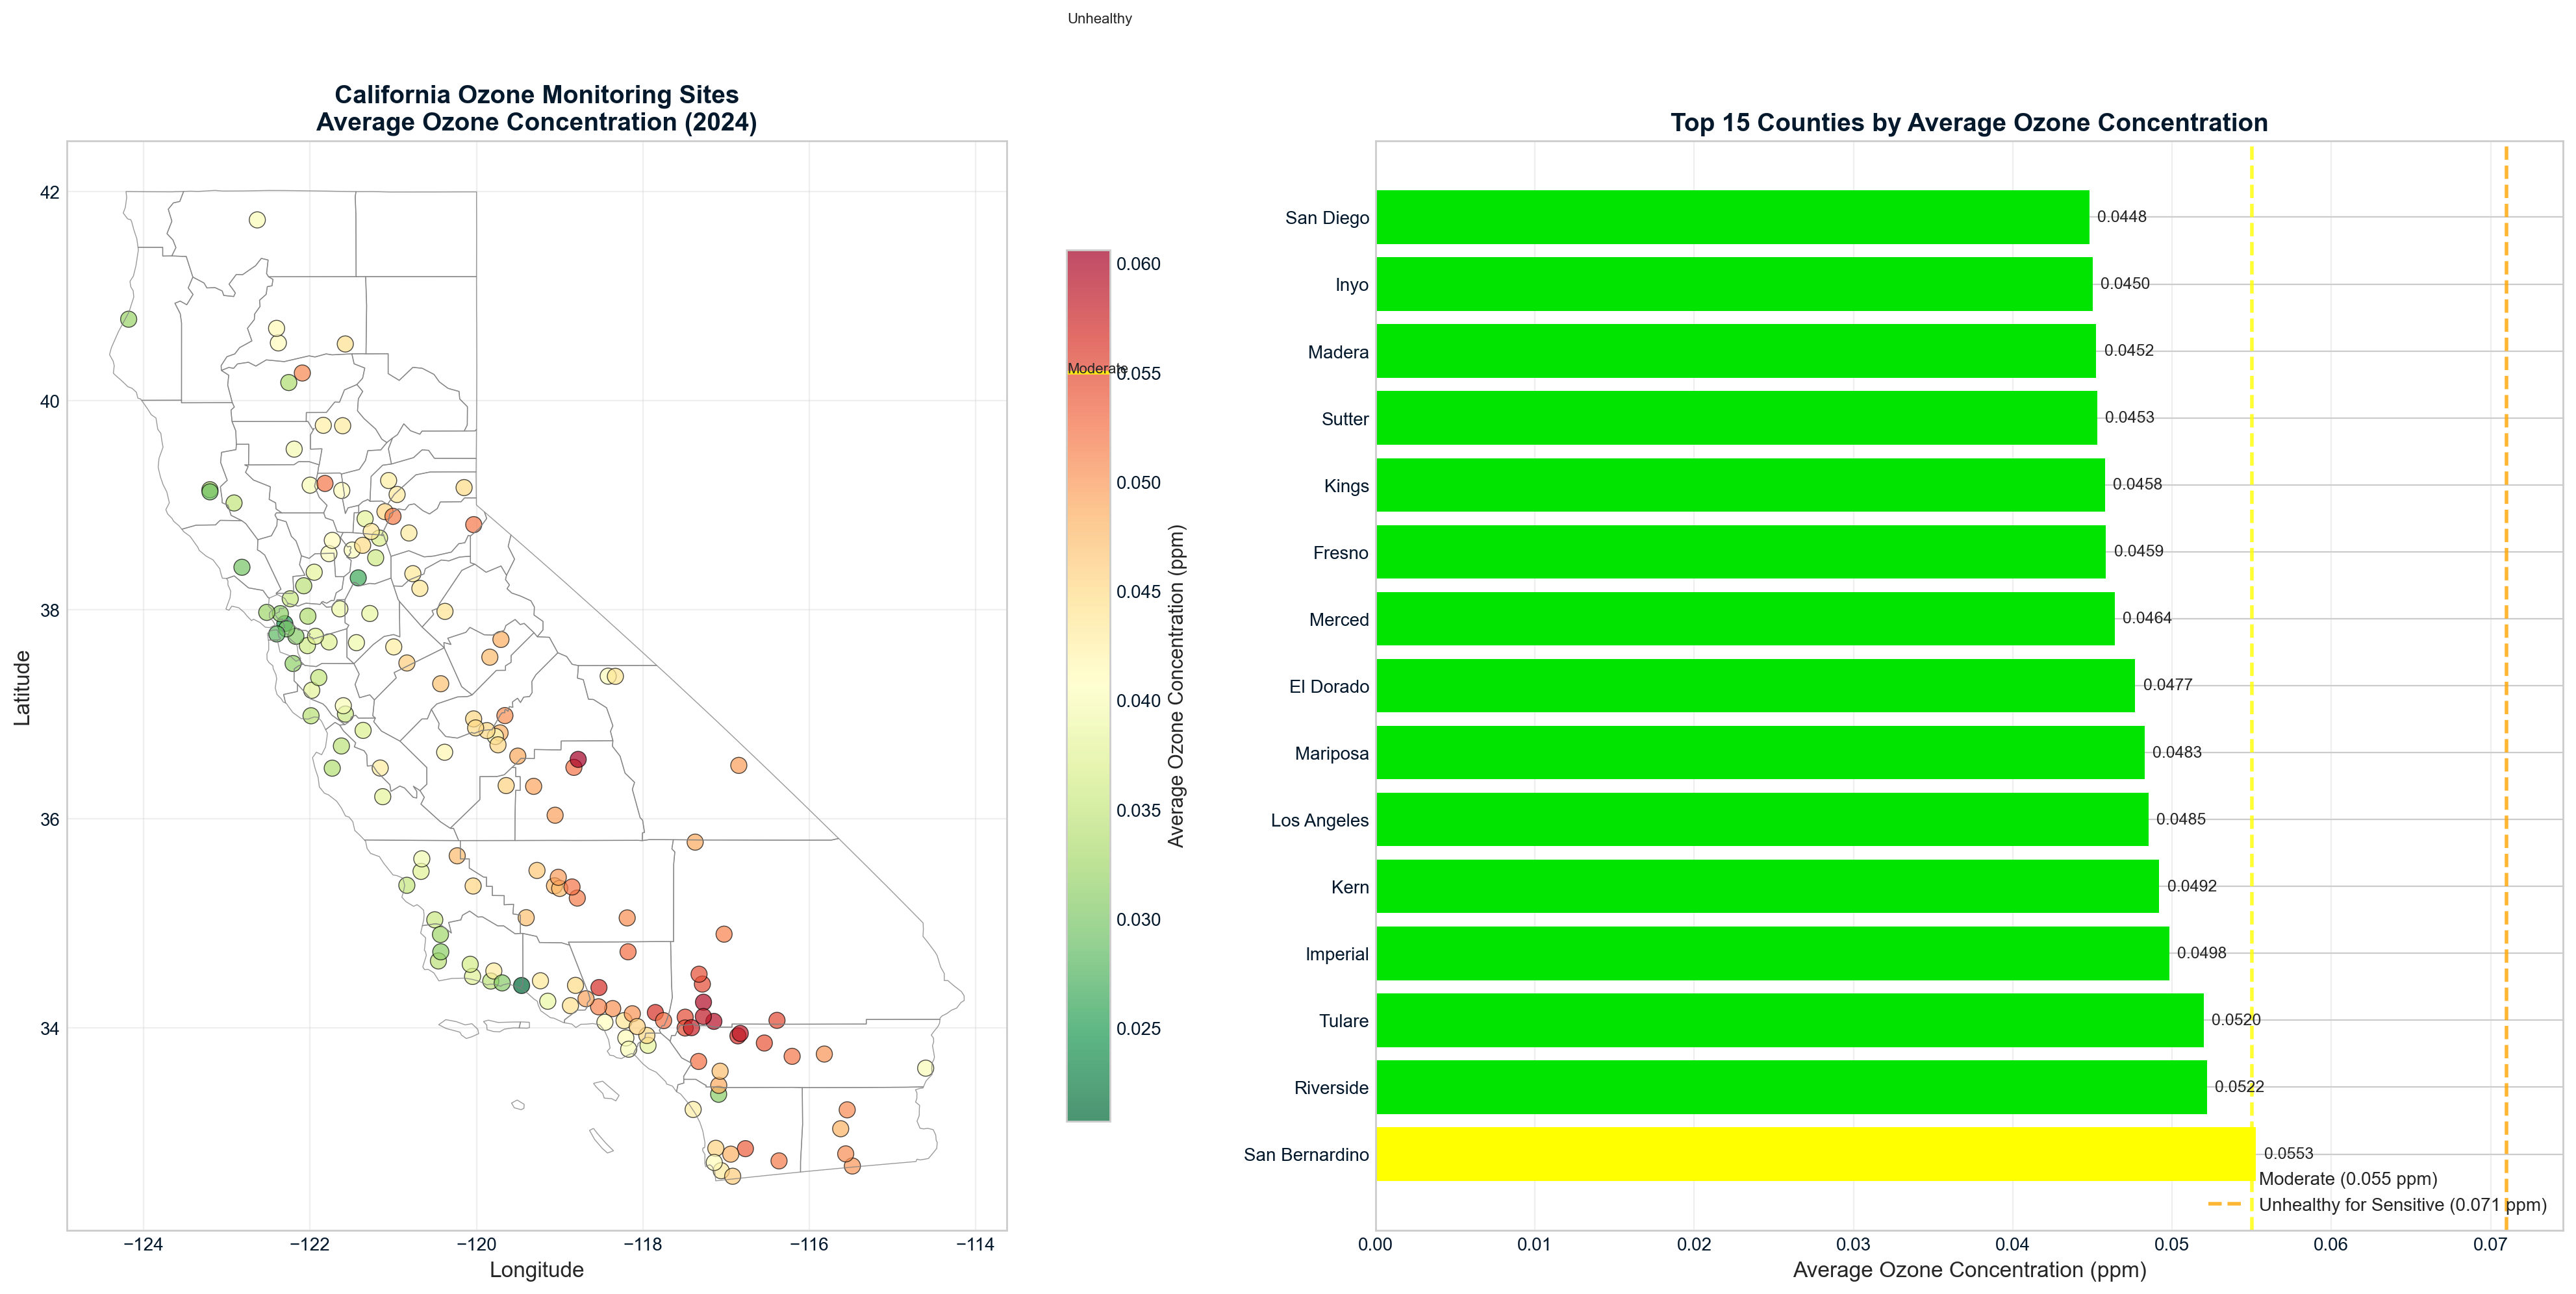

GEOSPATIAL ANALYSIS SUMMARY
• Total monitoring sites: 160
• Counties covered: 48
• Sites with Good air quality: 150 (93.8%)
• Sites with Moderate air quality: 10 (6.2%)
• Highest concentration site: Sequoia & Kings Canyon NPs - Lower Kaweah (0.0606 ppm)
• Most polluted county: San Bernardino (0.0553 ppm)


In [ ]:
# County-level analysis
print("County-level Ozone Analysis:")
print("=" * 50)

# Group by county and calculate statistics
county_stats = ozone_reduced.groupby('County').agg({
    'Daily Max 8-hour Ozone Concentration': ['mean', 'max', 'count', 'std'],
    'Daily AQI Value': ['mean', 'max'],
    'Site Latitude': 'mean',
    'Site Longitude': 'mean'
}).reset_index()

# Flatten column names
county_stats.columns = ['County', 'Avg_Ozone', 'Max_Ozone', 'Count', 'Std_Ozone', 
                       'Avg_AQI', 'Max_AQI', 'Avg_Lat', 'Avg_Lon']

# Filter counties with sufficient data
county_stats_filtered = county_stats[county_stats['Count'] >= 100].copy()
county_stats_filtered = county_stats_filtered.sort_values('Avg_Ozone', ascending=False)

print(f"Counties with sufficient data (≥100 measurements): {len(county_stats_filtered)}")
print("\nTop 10 Counties by Average Ozone Concentration:")
print(county_stats_filtered[['County', 'Avg_Ozone', 'Max_Ozone', 'Avg_AQI', 'Count']].head(10).round(4))

# Create static matplotlib visualisation
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

# Plot 1: Scatter plot of monitoring sites with ozone levels
scatter = ax1.scatter(site_summary_filtered['Longitude'], site_summary_filtered['Latitude'], 
                     c=site_summary_filtered['Avg_Ozone'], 
                     cmap='RdYlGn_r', 
                     s=80, 
                     alpha=0.7,
                     edgecolors='black',
                     linewidth=0.5)

# Add California county boundaries if available
if ca_counties is not None:
    ca_counties.boundary.plot(ax=ax1, color='gray', linewidth=0.5, alpha=0.8)

ax1.set_xlabel('Longitude', fontsize=12)
ax1.set_ylabel('Latitude', fontsize=12)
ax1.set_title('California Ozone Monitoring Sites\nAverage Ozone Concentration (2024)', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)

# Add colorbar
cbar1 = plt.colorbar(scatter, ax=ax1, shrink=0.8)
cbar1.set_label('Average Ozone Concentration (ppm)', fontsize=11)

# Add EPA threshold lines to colorbar
cbar1.ax.axhline(y=0.055, color='yellow', linewidth=2, alpha=0.8)
cbar1.ax.axhline(y=0.071, color='orange', linewidth=2, alpha=0.8)
cbar1.ax.text(0.02, 0.055, 'Moderate', transform=cbar1.ax.transData, fontsize=8)
cbar1.ax.text(0.02, 0.071, 'Unhealthy', transform=cbar1.ax.transData, fontsize=8)

# Plot 2: County-level bar chart
top_counties = county_stats_filtered.head(15)
bars = ax2.barh(range(len(top_counties)), top_counties['Avg_Ozone'], 
               color=[get_color_for_ozone(x) for x in top_counties['Avg_Ozone']])

ax2.set_yticks(range(len(top_counties)))
ax2.set_yticklabels(top_counties['County'], fontsize=10)
ax2.set_xlabel('Average Ozone Concentration (ppm)', fontsize=12)
ax2.set_title('Top 15 Counties by Average Ozone Concentration', fontsize=14, fontweight='bold')
ax2.grid(True, axis='x', alpha=0.3)

# Add EPA reference lines
ax2.axvline(x=0.055, color='yellow', linestyle='--', alpha=0.8, linewidth=2, label='Moderate (0.055 ppm)')
ax2.axvline(x=0.071, color='orange', linestyle='--', alpha=0.8, linewidth=2, label='Unhealthy for Sensitive (0.071 ppm)')

# Add value labels on bars
for i, (idx, row) in enumerate(top_counties.iterrows()):
    ax2.text(row['Avg_Ozone'] + 0.0005, i, f'{row["Avg_Ozone"]:.4f}', 
            va='center', fontsize=9)

ax2.legend(loc='lower right')

plt.tight_layout()
plt.show()

# Summary statistics
print("GEOSPATIAL ANALYSIS SUMMARY")
print(f"• Total monitoring sites: {len(site_summary_filtered)}")
print(f"• Counties covered: {len(county_stats_filtered)}")
print(f"• Sites with Good air quality: {len(site_summary_filtered[site_summary_filtered['Ozone_Category'] == 'Good'])} ({len(site_summary_filtered[site_summary_filtered['Ozone_Category'] == 'Good'])/len(site_summary_filtered)*100:.1f}%)")
print(f"• Sites with Moderate air quality: {len(site_summary_filtered[site_summary_filtered['Ozone_Category'] == 'Moderate'])} ({len(site_summary_filtered[site_summary_filtered['Ozone_Category'] == 'Moderate'])/len(site_summary_filtered)*100:.1f}%)")
print(f"• Highest concentration site: {top_polluted_sites.iloc[0]['Site_Name']} ({top_polluted_sites.iloc[0]['Avg_Ozone']:.4f} ppm)")
print(f"• Most polluted county: {county_stats_filtered.iloc[0]['County']} ({county_stats_filtered.iloc[0]['Avg_Ozone']:.4f} ppm)")

In [ ]:
map = folium.Map(location=[37.5, -119.5], zoom_start=6)
heat_data = [[row['Site Latitude'], row['Site Longitude'], row['Daily Max 8-hour Ozone Concentration']] 
             for index, row in ozone_reduced.dropna(subset=['Site Latitude', 'Site Longitude', 'Daily Max 8-hour Ozone Concentration']).iterrows()]
HeatMap(heat_data,name='Ozone Heatmap').add_to(map)
folium.Marker(
    location=[37.5, -119.5],
    popup=folium.Popup(
        "📍 Ozone Concentration Levels:<br>"
        "<b>🔴 Red</b>: High pollution<br>"
        "<b>🟠 Orange</b>: Moderate pollution<br>"
        "<b>🟢 Green</b>: Low pollution<br><br>"
        "This map shows areas with high ozone concentration using color intensity.",
        max_width=300
    ),
    icon=folium.Icon(color='blue', icon='info-sign')
).add_to(map)
folium.LayerControl().add_to(map)
map

The comprehensive geospatial visualisation reveals distinct spatial patterns in California's ozone pollution using both California county shapefiles and monitoring site locations:

### Key Geographic Findings

**1. Regional Pollution Hotspots:**
- **Inland Empire (San Bernardino & Riverside Counties)**: Consistently show the highest average ozone concentrations (0.0553 and 0.0522 ppm respectively)
- **Central Valley (Tulare, Kern, Fresno Counties)**: Form a corridor of elevated ozone levels running north-south through California's interior
- **Desert Regions (Imperial County)**: Show surprisingly high ozone levels (0.0498 ppm) despite low population density

**2. Geographic Protection Factors:**
- **Coastal Counties**: Generally maintain good air quality due to marine boundary layer effects and consistent sea breezes
- **Northern California**: Shows lower average concentrations, benefiting from cooler temperatures and different meteorological patterns
- **High Elevation Sites**: Some mountain monitoring stations show elevated readings, possibly due to ozone transport and formation at altitude

**3. Static Visualisation Features:**
- **160 monitoring sites** plotted with color-coded ozone levels
- **California county boundaries** overlaid using official US Census shapefiles
- **Dual plot format** showing both geographic distribution and county rankings
- **EPA threshold reference lines** and comprehensive statistical analysis

**4. Air Quality Distribution:**
- **93.8% of sites** maintain Good air quality (below 0.055 ppm)
- **6.2% of sites** reach Moderate levels (0.055-0.070 ppm)
- **0% of sites** exceed Unhealthy thresholds on average, though individual days may still reach these levels

**5. Most Critical Areas:**
- **Sequoia & Kings Canyon National Parks** (Lower Kaweah site): Highest average concentration at 0.0606 ppm
- **Crestline, San Bernardino County**: Mountain community with 0.0596 ppm average
- **Redlands, San Bernardino County**: Urban area with 0.0593 ppm average

The geospatial analysis confirms that California's ozone pollution follows a clear geographic pattern, with inland valleys and desert regions experiencing the highest concentrations while coastal areas remain relatively clean. This pattern reflects the complex interplay of emissions, topography, and meteorology that governs ozone formation and transport across the state.